# US Car Accident Severity Prediction

Traffic accidents have a significant effect on the safety of the public and the economy. Approximately around 1.25 million accidents are recorded world wide and is the fifth leading cause of death. The injury and the costs associated with accidents are a major cause of distress for individuals and families.

The primary objective of our research is to predict the severity of traffic accidents using advanced machine learning models. We have classified the accidents with four levels of severity:


*   Severity 1
*   Severity 2
*   Severity 3
*   Severity 4

We used the dataset hosted by "Sobhan Moosavi". This data is collected from various APIs that broadcast traffic events captured by a variety of entities, such as the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road-networks. The dataset contains over 7 million records. For our purpose we are using a sampled version of the dataset which contains 500k records.

[US Car Accidents Dataset](https://smoosavi.org/datasets/us_accidents).

# 1.1 Importing Required Libraries

In [3]:
# Installing required libraries
# %pip install category_encoders
# %pip install xgboost
!pip install --upgrade scikit-learn==1.3.0
!pip install --upgrade imbalanced-learn==0.11.0

  Obtaining dependency information for imbalanced-learn==0.11.0 from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ----------------- ---------------------- 102.4/235.6 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [1]:
# Importing required libraries

import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
from sklearn.ensemble import (
   RandomForestClassifier,
   AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Persistence and copy
import pickle
from copy import deepcopy

# Statistical modeling
import statsmodels.api as sm


# 1.2 Importing Input Dataset

In [9]:
# Reading input CSV file

accidents_raw = pd.read_csv("../data/us_accidents_data.csv")
accidents_cleaned = accidents_raw
accidents_cleaned.head()
accidents_cleaned.columns.tolist()

['ID',
 'Source',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'End_Lat',
 'End_Lng',
 'Distance(mi)',
 'Description',
 'Street',
 'City',
 'County',
 'State',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

# Data Cleaning

First, we'll look at the schema and feature definitions to see if there are any redudant or less important featurs that could be eliminated.

The data is provided in the form of a CSV file. Following table describes the data attributes:

""" Insert Table Details Here """

## 2.1 Dropping Unwanted Columns

After investigating the data definitions we can see that there a few columns which does not have any importance for the purpose of this project. Listed below are the features and the reason why they are being dropped.

*   ID: We don't require this feature since this is an unique identifier and doesn't contribute much to the analysis or prediction.
*   Source: This feature don't carry any information for the
*   End_Time: Since we are going to train a model to predict the severity of an accident we can't know in advance when the traffic flow will become normal again.
*   Description: We don't require the description as this is highly cardinal and is not important for predicting the severity.
*   Street, County, State, Zipcode, Country: We dont require these features because we just focus on the City where the accident happened.
*   Timezone, Airport_Code, Weather_Timestamp: These features are not useful for our task.
*   Turning_Loop: This variable has no significance since it's value is always false.
*   Sunrise_Sunset, Nautical_Twilight, Astronomical_Twilight: We don't need these since these features are similar to Civil_Twilight and are redundant.









In [10]:
features_to_drop = [
    "ID"
    , "Source"
    , "End_Time"
    , "Description"
    , "Street"
    , "County"
    , "State"
    , "Zipcode"
    , "Country"
    , "Timezone"
    , "Airport_Code"
    , "Weather_Timestamp"
    , "Turning_Loop"
    , "Sunrise_Sunset"
    , "Nautical_Twilight"
    , "Astronomical_Twilight"
    ]

# Drop unwanted features
accidents_cleaned.drop(columns=features_to_drop, inplace=True)

## 2.2 Removing Duplicate Records

We will now investigate the dataset to check if there are any duplicates present. Presence of duplicates might skew the statistical measures, affect the model's accuracy and might lead to inaccurate conclusions. Thus it is very important to remove duplicates before we draw any conclusions from the data.

In [11]:
print("Total number of records: ", len(accidents_cleaned))
accidents_cleaned.drop_duplicates(inplace=True)
print("Total number of records after dropping duplicates: ", len(accidents_cleaned))

Total number of records:  500000
Total number of records after dropping duplicates:  498254


## 2.3 Removing Records Having Erroneous Values

There are cases where some of the fields might have erroneous values. For example if the values for an attribute is not available they might contain some default values like "NA" or "0" depending on what the variable describes.

Thus identifying and removing those is as important as removing duplicate records.

In [12]:
accidents_cleaned.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,498254.000000,498254.000000,498254.000000,277920.000000,277920.000000,498254.000000,487822.000000,369315.000000,487159.000000,489359.000000,487001.000000,461323.000000,355724.000000
mean,2.213323,36.210852,-94.747836,36.281396,-95.801602,0.563949,61.643511,58.214806,64.838730,29.537042,9.091381,7.680481,0.008293
std,0.487047,5.067661,17.405010,5.259925,18.121480,1.774586,19.001165,22.359259,22.826649,1.008231,2.708499,5.430834,0.102002
min,1.000000,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000
25%,2.000000,33.422438,-117.234922,33.483328,-117.787219,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000
50%,2.000000,35.834070,-87.813018,36.200868,-88.062595,0.028000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000
75%,2.000000,40.083319,-80.363971,40.183928,-80.258014,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000
max,4.000000,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000


The descriptive statistics obtained from the dataset indicates that there are few features with some erroneous values. More specifically the feature - "Visibility(mi)" - has zeros for some of the records.

While features like "Wind Speed", and "Precipitation" can have zeros "Visibility" cannot and thus we'll be removing those records from the dataset.

In [7]:
print("Records with Zero Visibitlity:", sum(accidents_cleaned["Visibility(mi)"] == 0))

Records with Zero Visibitlity: 515


In [13]:
# Remove records with erroneous values

accidents_cleaned = accidents_cleaned[accidents_cleaned["Visibility(mi)"] != 0]
print("Number of records:", len(accidents_cleaned))

Number of records: 497739


## 2.4 Removing Records with Null Values

Handling null values is an important step in data cleaning and in a machine learning pipeline.

The presence of null values distort statistical measures and leads to incorrect conclusions. Furthermore, including nulls will result in a biased model which struggles to perform well when used on unseen data.

Thus it is imperative to remove nulls from the dataset before training a model and we'll do the same.

In [14]:
accidents_cleaned.isna().sum()

Severity                  0
Start_Time                0
Start_Lat                 0
Start_Lng                 0
End_Lat              220196
End_Lng              220196
Distance(mi)              0
City                     19
Temperature(F)        10425
Wind_Chill(F)        128911
Humidity(%)           11081
Pressure(in)           8895
Visibility(mi)        11253
Wind_Direction        11138
Wind_Speed(mph)       36921
Precipitation(in)    142497
Weather_Condition     11061
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Civil_Twilight         1473
dtype: int64

From the above results we can see that almost 30% of the records of the feature "Precipitation" are null. Thus we'll drop this feature. Other features like Humidity, Pressure, and Wind Speed have a few null values and we'll drop those records for these features.

In [15]:
accidents_cleaned.drop(columns="Precipitation(in)", inplace=True)

C:\Users\mkalw\AppData\Local\Temp\ipykernel_28416\3569387599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_cleaned.drop(columns="Precipitation(in)", inplace=True)


In [16]:
# Removing nulls

accidents_cleaned.dropna(
    subset=["City", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Weather_Condition", "Civil_Twilight"],
    inplace=True
    )
print("Number of records:", len(accidents_cleaned))
accidents_cleaned.columns

Number of records: 454683


C:\Users\mkalw\AppData\Local\Temp\ipykernel_28416\1839018560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_cleaned.dropna(


Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'End_Lat',
       'End_Lng', 'Distance(mi)', 'City', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight'],
      dtype='object')

## 2.5 Standardizing Data Format

It is necessary to maintain consistent format across all the records for dataframe features to enhance the clarity and to reduce any potential confusion.

Imagine a situation where a dataset contains the feature length but the values are provided in inches for some of the records and in meters for others. This creates confusion as to how to interpret the data.

Thus we need to maintain consistent data formats.





In [17]:
accidents_cleaned["Distance(mi)"].astype(str).str \
    .extract(r"^.*\.([\d]*)$")[0] \
    .astype(str).str.len().unique()

array([ 1,  3, 16,  2, 15, 14, 13], dtype=int64)

Looking at the results it is clear that the format for the feature "Distance" is inconsistent. Thus we'll round the feature to three decimal places to make it consistent.

In [ ]:
# Trimming decimals

accidents_cleaned["Distance(mi)"] = accidents_cleaned["Distance(mi)"].apply(lambda ele: round(ele, 3))
accidents_cleaned["Distance(mi)"].astype(str).str 
    .extract(r"^.*\.([\d]*)$")[0] \
    .astype(str).str.len().unique()

C:\Users\ajayv\AppData\Local\Temp\ipykernel_27008\1092667291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_cleaned["Distance(mi)"] = accidents_cleaned["Distance(mi)"].apply(lambda ele: round(ele, 3))


array([1, 3, 2], dtype=int64)

## 2.6 Removing Outliers

One of the important parts in data cleaning is removing the outliers. Outliers distort the statiscal analyses which can affect mean, standard deviation and other statistical measures. Outliers does affect important assumptions that we make on data. Thus we should remove the outliers to ensure the model to have good understanding of the data and therby to improve the prediction accuracy.

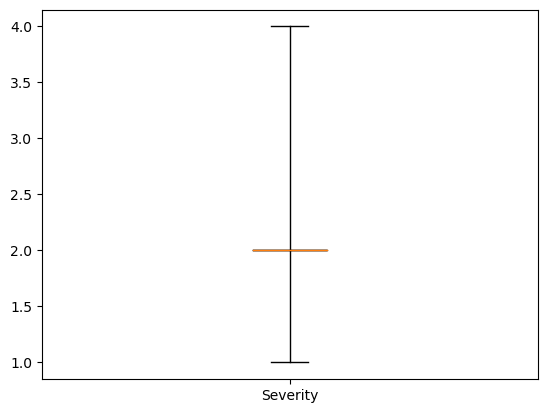

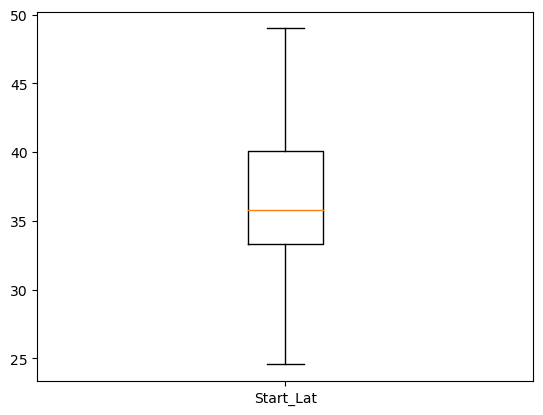

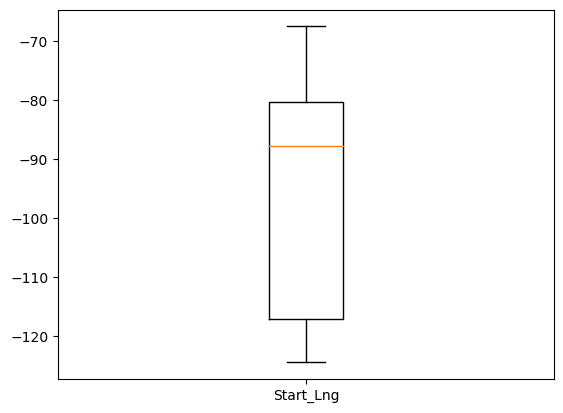

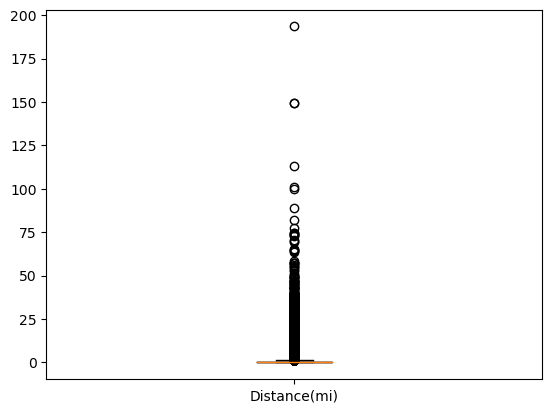

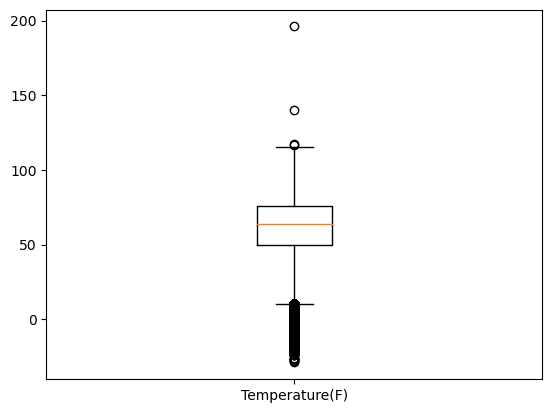

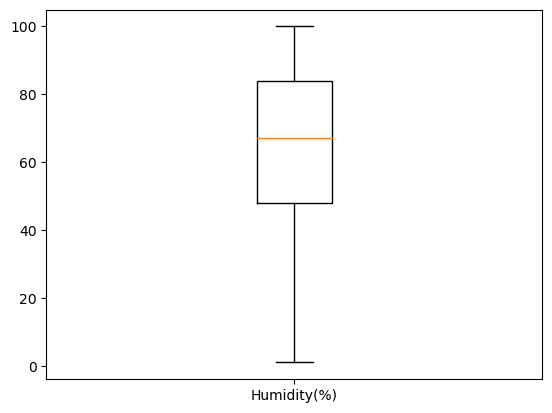

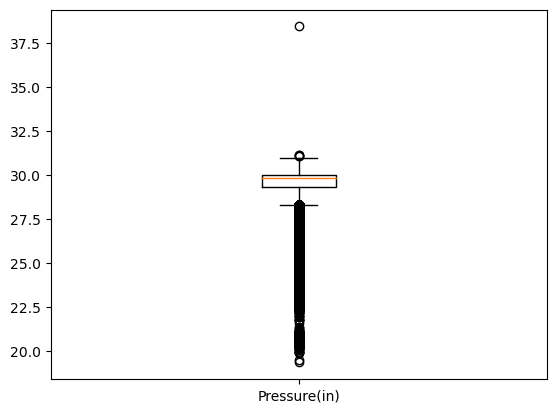

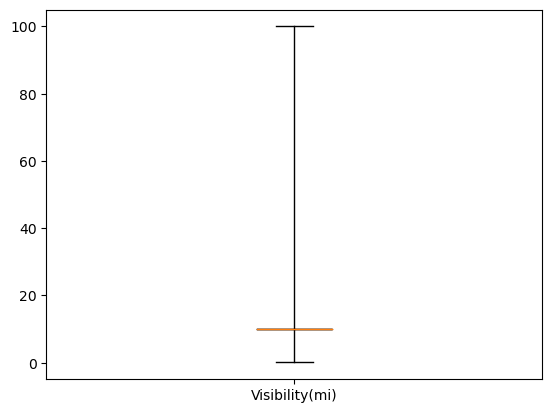

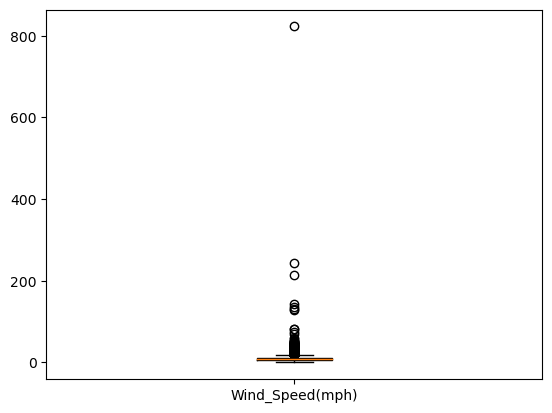

In [14]:
# Box plots

for col in accidents_cleaned.select_dtypes(include=["int", "float"]).columns:
    if col not in ["End_Lat", "End_Lng", "Wind_Chill(F)"]:
        plt.boxplot(accidents_cleaned[col], labels=[col], autorange=True)
        plt.show()

From the box plots we can infer that there are outliers present in the following features:

*   Temperature
*   Pressure

Removing outliers from the training dataset improves the performance of the model and thus we'll remove the features mentioned above.

In [15]:
# Removing outliers using IQR

for col in ["Temperature(F)", "Pressure(in)"]:
    quantile_25 = accidents_cleaned[col].quantile(0.25)
    quantile_75 = accidents_cleaned[col].quantile(0.75)

    upper_bound = quantile_75 + (quantile_75 - quantile_25) * 1.5

    accidents_cleaned = accidents_cleaned[accidents_cleaned[col] <= upper_bound]

## 2.7 Handling Datetime Features

It is very important to handle datetime features correctly. Datetime features encode time realted information which will be useful in analyzing trends and cyclical patterns[1].

Splitting the "Start Time" column into multiple columns such as Year, Month, Day, Hour, Weekday.This will help us to perform better analyses of the Severity of accidents across the different time frames.

[1] [Handling Datetime Features](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)

In [16]:
# Convert the start_time column to datetime format
accidents_cleaned['Start_Time'] = pd.to_datetime(accidents_cleaned['Start_Time'])

# Extract year, month, day, hour, and weekday from the start_time column
accidents_cleaned['Year'] = accidents_cleaned['Start_Time'].dt.year
accidents_cleaned['Month'] = accidents_cleaned['Start_Time'].dt.month
accidents_cleaned['Day'] = accidents_cleaned['Start_Time'].dt.day
accidents_cleaned['Hour'] = accidents_cleaned['Start_Time'].dt.hour
accidents_cleaned['Weekday'] = accidents_cleaned['Start_Time'].dt.weekday

# Drop the original start_time column
accidents_cleaned = accidents_cleaned.drop('Start_Time', axis=1)

# Print the transformed dataframe
accidents_cleaned.head()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),City,Temperature(F),Wind_Chill(F),Humidity(%),...,Station,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Day,Hour,Weekday
0,2,30.641211,-91.153481,NaN,NaN,0.000,Zachary,77.0,77.0,62.0,...,False,False,False,True,Day,2019,6,12,10,2
1,2,38.990562,-77.399070,38.990037,-77.398282,0.056,Sterling,45.0,43.0,48.0,...,False,False,False,False,Night,2022,12,3,23,5
2,2,34.661189,-120.492822,34.661189,-120.492442,0.022,Lompoc,68.0,68.0,73.0,...,False,False,False,True,Day,2022,8,20,13,5
3,2,43.680592,-92.993317,43.680574,-92.972223,1.054,Austin,27.0,15.0,86.0,...,False,False,False,False,Day,2022,2,21,17,0
4,2,35.395484,-118.985176,35.395476,-118.985995,0.046,Bakersfield,42.0,42.0,34.0,...,False,False,False,False,Night,2020,12,4,1,4


## 2.8 Feature Modification

Analyzing the categorical columns in the dataset reveals crucial information about how different cateogory might impact the model performance. Having many categories will make the model more complicated and it might suffer from the curse of dimensionality. It affects the model stability, performance and potentially could overfit the data.

In [17]:
accidents_cleaned.select_dtypes(include=["object"]).head()

,City,Wind_Direction,Weather_Condition,Civil_Twilight
0,Zachary,NW,Fair,Day
1,Sterling,W,Fair,Night
2,Lompoc,W,Fair,Day
3,Austin,ENE,Wintry Mix,Day
4,Bakersfield,CALM,Fair,Night


In [18]:
accidents_cleaned["Wind_Direction"].unique()

array(['NW', 'W', 'ENE', 'CALM', 'SW', 'VAR', 'S', 'E', 'WSW', 'NNE',
       'Variable', 'West', 'N', 'ESE', 'NNW', 'North', 'SSW', 'WNW', 'NE',
       'SE', 'East', 'SSE', 'South'], dtype=object)

In [19]:
accidents_cleaned["Weather_Condition"].unique()

array(['Fair', 'Wintry Mix', 'Light Rain', 'Cloudy', 'Mostly Cloudy',
       'Partly Cloudy', 'Clear', 'Scattered Clouds', 'Fog', 'Overcast',
       'Light Snow', 'T-Storm', 'Thunderstorms and Rain', 'Thunder',
       'Light Rain with Thunder', 'Rain', 'Showers in the Vicinity',
       'Mostly Cloudy / Windy', 'Heavy Rain', 'Cloudy / Windy',
       'Light Drizzle', 'Heavy T-Storm', 'Light Rain / Windy', 'Smoke',
       'Blowing Dust / Windy', 'Haze', 'N/A Precipitation',
       'Thunder in the Vicinity', 'Snow', 'Heavy Thunderstorms and Rain',
       'Light Freezing Drizzle', 'Fair / Windy', 'Patches of Fog',
       'Light Snow / Windy', 'Blowing Snow / Windy', 'Thunderstorm',
       'Drizzle', 'T-Storm / Windy', 'Partly Cloudy / Windy',
       'Shallow Fog', 'Heavy Rain / Windy', 'Heavy Snow / Windy', 'Mist',
       'Light Thunderstorms and Rain', 'Rain / Windy',
       'Light Freezing Rain', 'Heavy Snow', 'Light Ice Pellets',
       'Heavy T-Storm / Windy', 'Heavy Drizzle', 'Sleet',


In [20]:
accidents_cleaned["Civil_Twilight"].unique()

array(['Day', 'Night'], dtype=object)

We can see from above the features "Wind Direction" and "Weather Condition" have too many unique values. So we'll modify these features to reduce the number of unique categories.

In [21]:
accidents_encoded_scaled = accidents_cleaned

accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

accidents_encoded_scaled["Weather_Condition"].unique()

array(['Clear', 'Snow', 'Rain', 'Cloudy', 'Fog', 'Thunderstorm', 'Windy',
       'Smoke', nan, 'Hail', 'Sand', 'Tornado'], dtype=object)

In [22]:
accidents_encoded_scaled.loc[accidents_encoded_scaled["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Wind_Direction"] == "East", "Wind_Direction"] = "E"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Wind_Direction"] == "North", "Wind_Direction"] = "N"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Wind_Direction"] == "South", "Wind_Direction"] = "S"
accidents_encoded_scaled.loc[accidents_encoded_scaled["Wind_Direction"] == "West", "Wind_Direction"] = "W"

accidents_encoded_scaled["Wind_Direction"] = accidents_encoded_scaled["Wind_Direction"] \
  .map(lambda accidents_encoded_scaled :
       accidents_encoded_scaled if len(accidents_encoded_scaled) != 3 else accidents_encoded_scaled[1:]
       , na_action="ignore"
  )

accidents_encoded_scaled["Wind_Direction"].unique()

array(['NW', 'W', 'NE', 'Calm', 'SW', 'Variable', 'S', 'E', 'N', 'SE'],
      dtype=object)

## 2.9 Feature Encoding

Feature encoding is a crucial step in the machine learning pipeline. It is carried out to convert categorical data into numerical values which will then be used by the models. We do this step because machine learning models only operate on numerical values. It will be next to impossible for the models to interpret these features without converting them. There are many ways to encode features and it depends on the type of the data.

We'll try to understand what type of categorical data we have in our dataset and perform appropriate encoding technique to convert them.

In [23]:
categorical_features = set(["City", "Wind_Direction", "Weather_Condition", "Civil_Twilight"])

# One Hot Encoding
accidents_encoded_scaled = pd.get_dummies(
    accidents_encoded_scaled,
    columns=list(categorical_features - set(["City"])),
    drop_first=True
)

# Binary Encoding
binary_encoder = ce.binary.BinaryEncoder()
city_encoded = binary_encoder.fit_transform(accidents_encoded_scaled["City"])
accidents_encoded_scaled = pd.concat([accidents_encoded_scaled, city_encoded], axis=1).drop("City", axis=1)

# Label Encoding
accidents_encoded_scaled = accidents_encoded_scaled.replace([True, False], [1, 0])

We'll use one hot encoding for the features "Wind Direction", "Weather Condition", and "Civil Twilight". We only have a few unique values for these columns and one hot encoding would be great fit for this purpose.

Similarly, we'll use binary encoding for the feature "City". We do this because there are around 6000 unique values for this feature and using binary encoding would be the right choice.

We can also see there are a few columns which only have Boolean values and we'll encode them to have either a 0 or a 1.



```
# This is formatted as code
```

## 2.10 Feature Scaling

Feature scaling is necessary when dealing with datasets containing features that have different ranges, units of measurement or orders of magnitude. In such cases, the variations could lead to a biased model thus reducing the model's efficiency.

We'll be using a min-max scaler for our purpose.

In [24]:
scaler = MinMaxScaler()
features = [
    'Temperature(F)'
    , 'Distance(mi)'
    , 'Humidity(%)'
    , 'Pressure(in)'
    , 'Visibility(mi)'
    , 'Wind_Speed(mph)'
    , 'Start_Lng'
    , 'Start_Lat'
    , 'Year'
    , 'Month'
    , 'Day'
    , 'Hour'
    , 'Weekday'
]

accidents_encoded_scaled[features] = scaler.fit_transform(accidents_encoded_scaled[features])
accidents_encoded_scaled.head()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
0,2,0.248761,0.584845,NaN,NaN,0.000000,0.736111,77.0,0.616162,0.910345,...,0,0,0,0,0,0,0,0,0,1
1,2,0.590423,0.826094,38.990037,-77.398282,0.000289,0.513889,43.0,0.474747,0.909483,...,0,0,0,0,0,0,0,0,1,0
2,2,0.413262,0.070240,34.661189,-120.492442,0.000114,0.673611,68.0,0.727273,0.899138,...,0,0,0,0,0,0,0,0,1,1
3,2,0.782343,0.552575,43.680574,-92.972223,0.005448,0.388889,15.0,0.858586,0.787069,...,0,0,0,0,0,0,0,1,0,0
4,2,0.443310,0.096683,35.395476,-118.985995,0.000238,0.493056,42.0,0.333333,0.897414,...,0,0,0,0,0,0,0,1,0,1


# Explanatory Data Analysis

Explanatory Data Analysis helps in getting a deeper understanding of the data we have. It helps in identifying any patterns or trends that we have in data. By visualizing the data we can uncover many insights.

In [25]:
accidents_cleaned.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'City', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Year',
       'Month', 'Day', 'Hour', 'Weekday'],
      dtype='object')

## 3.1 Top 5 Cities by Accident Counts



In [26]:
accidents_cleaned['City'].value_counts().head(5)

Miami          11546
Houston        10124
Los Angeles     8647
Charlotte       8256
Dallas          7937
Name: City, dtype: int64

We will create four seperate data frames based on the four types of Severity the data has. We can anlayse and check individually these data frames based on the type of *Severity*.

In [27]:
Severity4=accidents_cleaned.loc[accidents_cleaned['Severity']==4];
Severity3=accidents_cleaned.loc[accidents_cleaned['Severity']==3];
Severity2=accidents_cleaned.loc[accidents_cleaned['Severity']==2];
Severity1=accidents_cleaned.loc[accidents_cleaned['Severity']==1];

In [28]:
Severity2.count()

Severity             365198
Start_Lat            365198
Start_Lng            365198
End_Lat              238583
End_Lng              238583
Distance(mi)         365198
City                 365198
Temperature(F)       365198
Wind_Chill(F)        306236
Humidity(%)          365198
Pressure(in)         365198
Visibility(mi)       365198
Wind_Direction       365198
Wind_Speed(mph)      365198
Weather_Condition    365028
Amenity              365198
Bump                 365198
Crossing             365198
Give_Way             365198
Junction             365198
No_Exit              365198
Railway              365198
Roundabout           365198
Station              365198
Stop                 365198
Traffic_Calming      365198
Traffic_Signal       365198
Civil_Twilight       365198
Year                 365198
Month                365198
Day                  365198
Hour                 365198
Weekday              365198
dtype: int64

## 3.2 Cities With Highest Severity 4 Accidents

In [29]:
Severity4['City'].value_counts().head(5)

Atlanta    176
Miami      132
Orlando     75
Dallas      71
Houston     61
Name: City, dtype: int64

Atlanta and Miami are the cities leading with the most Severity4 accidents having 176 and 132 accidents respectively.

## 3.3 1D Visualization

1D plot helps in understanding the distribution of each features individually. 1D plot helps in assessing the central tendecy, spread and skewness of the data. Moreover 1D plot helps in revealing the patterns of missing data.

Text(0.5, 0, 'Wind_Chill(F)')

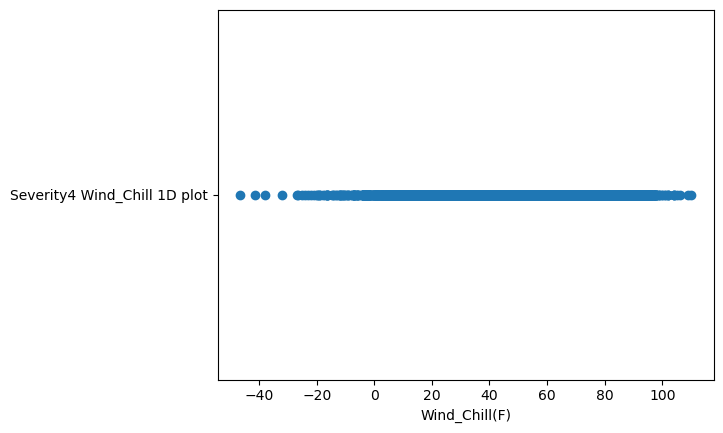

In [30]:
plt.plot(Severity4['Wind_Chill(F)'],np.zeros_like(Severity4['Wind_Chill(F)']),'o')
plt.plot('Severity4 Wind_Chill 1D plot')
plt.xlabel('Wind_Chill(F)')

We can see that the feature "Wind Chill(F)" for the Severity 4 accidents varies from -50F to 110F.

Text(0.5, 0, 'Wind_Chill(F)')

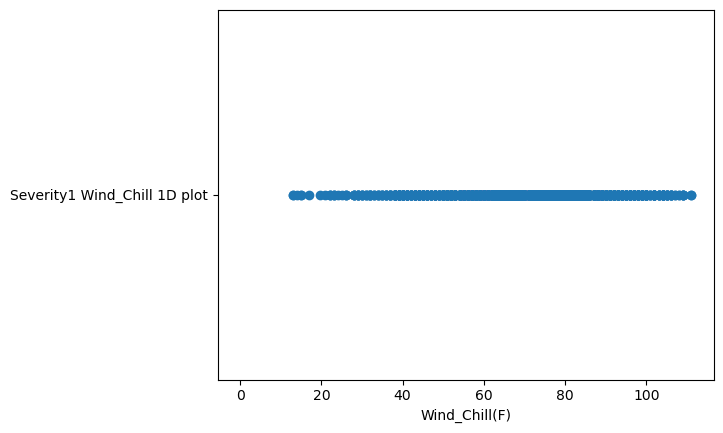

In [31]:
plt.plot(Severity1['Wind_Chill(F)'],np.zeros_like(Severity1['Wind_Chill(F)']),'o')
plt.plot('Severity1 Wind_Chill 1D plot')
plt.xlabel('Wind_Chill(F)')

We can see that the feature "Wind Chill(F)" for the Severity 1 accidents varies from 20F to 110F.

Text(0.5, 0, 'Visibility(mi)')

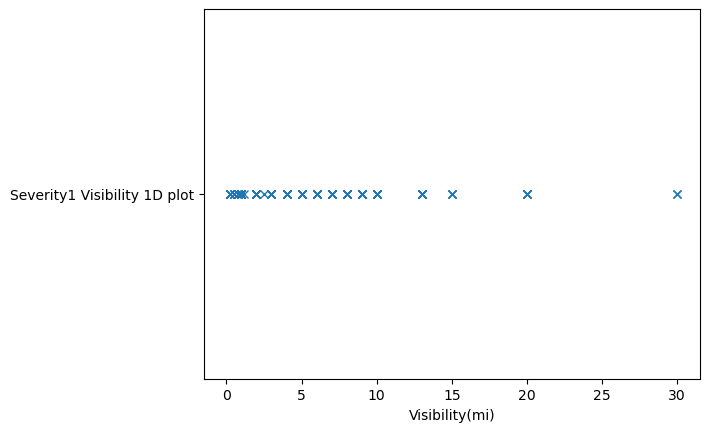

In [32]:
plt.plot(Severity1['Visibility(mi)'],np.zeros_like(Severity1['Visibility(mi)']),'x')
plt.plot('Severity1 Visibility 1D plot')
plt.xlabel('Visibility(mi)')

Text(0.5, 0, 'Visibility(mi)')

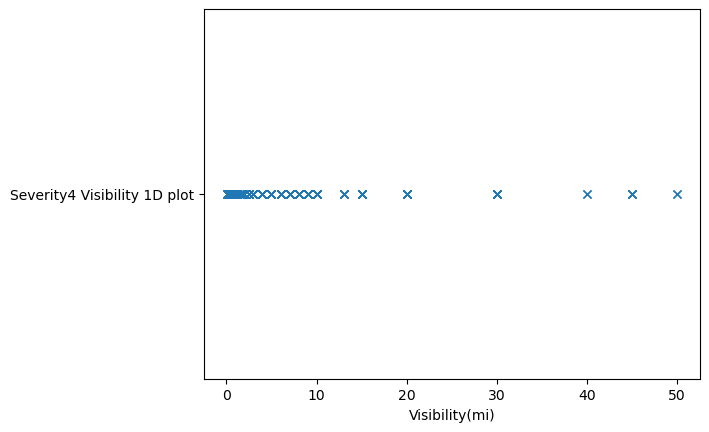

In [33]:
plt.plot(Severity4['Visibility(mi)'],np.zeros_like(Severity4['Visibility(mi)']),'x')
plt.plot('Severity4 Visibility 1D plot')
plt.xlabel('Visibility(mi)')

There is not much difference between the visibilities during "Severity 4" and "Severity 1" accidents.

In [34]:
print(Severity4[Severity4['Bump']==True].count())
print(Severity2[Severity2['Bump']==True].count())

Severity             4
Start_Lat            4
Start_Lng            4
End_Lat              4
End_Lng              4
Distance(mi)         4
City                 4
Temperature(F)       4
Wind_Chill(F)        2
Humidity(%)          4
Pressure(in)         4
Visibility(mi)       4
Wind_Direction       4
Wind_Speed(mph)      4
Weather_Condition    4
Amenity              4
Bump                 4
Crossing             4
Give_Way             4
Junction             4
No_Exit              4
Railway              4
Roundabout           4
Station              4
Stop                 4
Traffic_Calming      4
Traffic_Signal       4
Civil_Twilight       4
Year                 4
Month                4
Day                  4
Hour                 4
Weekday              4
dtype: int64
Severity             173
Start_Lat            173
Start_Lng            173
End_Lat              126
End_Lng              126
Distance(mi)         173
City                 173
Temperature(F)       173
Wind_Chill(F)        155
Hum

It can be seen that in "Severity 4" accidents bump count is lesser when compared to others. When the bump count is higher, the severity is lesser.

In [35]:
print(Severity4['Distance(mi)'].mean())
print(Severity1['Distance(mi)'].mean())

1.4860856343935687
0.112300243902439


It is seen that the average length of the road extent affected by the accident in Severity4 is 1.483 miles and by Severity1 is 0.111 miles.

Text(0.5, 0, 'Distance(mi)')

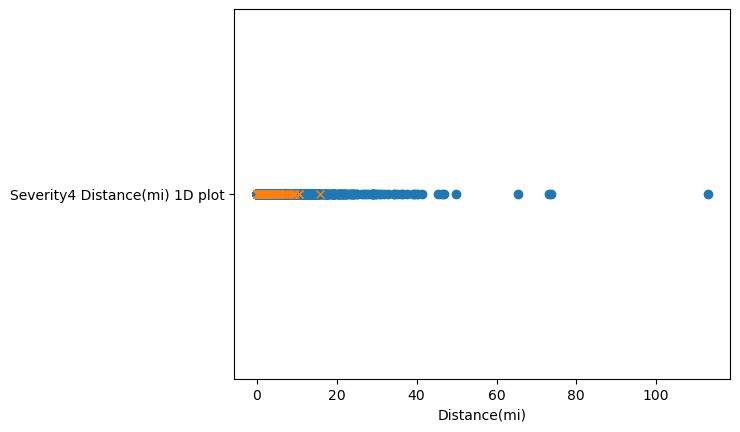

In [36]:
plt.plot(Severity4['Distance(mi)'],np.zeros_like(Severity4['Distance(mi)']),'o')
plt.plot(Severity1['Distance(mi)'],np.zeros_like(Severity1['Distance(mi)']),'x')
plt.plot('Severity4 Distance(mi) 1D plot')
plt.xlabel('Distance(mi)')

It is clearly visible that the length of the road extent affected by the accident in Severity4 is higher when compared to other Severities

## 3.4 2D Scatter Plot

Scatter plot helps to visually find the relationship between two variables. It can be interpreted easily to find complex patterns in the data.

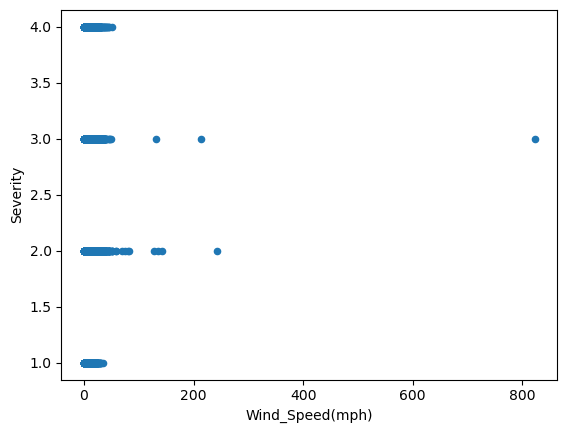

In [37]:
accidents_cleaned.plot(kind = 'scatter', x='Wind_Speed(mph)', y='Severity')
plt.show()

## 3.5 Removing Out of Range Values

There may be errors in uploading or entering the data. By removing these values we can improve the quality further which can improve the accuracy.

In [38]:
print("Records with Wind_Speed(mph):", sum(accidents_cleaned["Wind_Speed(mph)"] > 200))
'The Highest Windspeed recorded on a day is 250mp,so lets remove those which are above 200mph since those might be wrongly noted'
print("Total number of records: ", len(accidents_cleaned))
accidents_cleaned = accidents_cleaned[accidents_cleaned['Wind_Speed(mph)'] <= 200]
print("Total number of records after removing the wind speed greater than 200: ", len(accidents_cleaned))

Records with Wind_Speed(mph): 3
Total number of records:  454674
Total number of records after removing the wind speed greater than 200:  454671


In [39]:
print(Severity4[Severity4['Traffic_Signal']==True].count())
print(Severity4.count())

Severity             1113
Start_Lat            1113
Start_Lng            1113
End_Lat              1093
End_Lng              1093
Distance(mi)         1113
City                 1113
Temperature(F)       1113
Wind_Chill(F)         880
Humidity(%)          1113
Pressure(in)         1113
Visibility(mi)       1113
Wind_Direction       1113
Wind_Speed(mph)      1113
Weather_Condition    1113
Amenity              1113
Bump                 1113
Crossing             1113
Give_Way             1113
Junction             1113
No_Exit              1113
Railway              1113
Roundabout           1113
Station              1113
Stop                 1113
Traffic_Calming      1113
Traffic_Signal       1113
Civil_Twilight       1113
Year                 1113
Month                1113
Day                  1113
Hour                 1113
Weekday              1113
dtype: int64
Severity             11444
Start_Lat            11444
Start_Lng            11444
End_Lat              10561
End_Lng              

We can see that there were just around 1100 signals out of 11446, just 10% of the places had signals in Severity4.

In [40]:
print(Severity1[Severity1['Traffic_Signal']==True].count())
print(Severity1.count())

Severity             1623
Start_Lat            1623
Start_Lng            1623
End_Lat               833
End_Lng               833
Distance(mi)         1623
City                 1623
Temperature(F)       1623
Wind_Chill(F)        1619
Humidity(%)          1623
Pressure(in)         1623
Visibility(mi)       1623
Wind_Direction       1623
Wind_Speed(mph)      1623
Weather_Condition    1623
Amenity              1623
Bump                 1623
Crossing             1623
Give_Way             1623
Junction             1623
No_Exit              1623
Railway              1623
Roundabout           1623
Station              1623
Stop                 1623
Traffic_Calming      1623
Traffic_Signal       1623
Civil_Twilight       1623
Year                 1623
Month                1623
Day                  1623
Hour                 1623
Weekday              1623
dtype: int64
Severity             4100
Start_Lat            4100
Start_Lng            4100
End_Lat              1722
End_Lng              1722

It can be seen that Severity1 has around 40% traffic signals.

In [41]:
# Remove duplicate records
accidents_cleaned.drop_duplicates(inplace=True)

# Remove records with erroneous values
accidents_cleaned = accidents_cleaned[accidents_cleaned["Visibility(mi)"] != 0]

# Remove records with null values
accidents_cleaned.dropna(
    subset=["City", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Weather_Condition", "Civil_Twilight"],
    inplace=True
)

# Standardize data format
accidents_cleaned["Distance(mi)"] = accidents_cleaned["Distance(mi)"].apply(lambda ele: round(ele, 3))

# Remove outliers
for col in accidents_cleaned.select_dtypes(include=["int", "float"]).columns:
    if col not in ["End_Lat", "End_Lng", "Wind_Chill(F)"]:
        Q1 = accidents_cleaned[col].quantile(0.25)
        Q3 = accidents_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        accidents_cleaned = accidents_cleaned[(accidents_cleaned[col] >= lower_bound) & (accidents_cleaned[col] <= upper_bound)]


C:\Users\ajayv\AppData\Local\Temp\ipykernel_27008\3428148493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_cleaned.drop_duplicates(inplace=True)


In [42]:
accidents_cleaned.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'City', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Year',
       'Month', 'Day', 'Hour', 'Weekday'],
      dtype='object')

## 3.6 Heat Map for Correlation

Heat Map for correlation plot helps in knowing about the highly correlated features. This helps in selecting the features as it helps in selecting the important features for predicting the output variable.

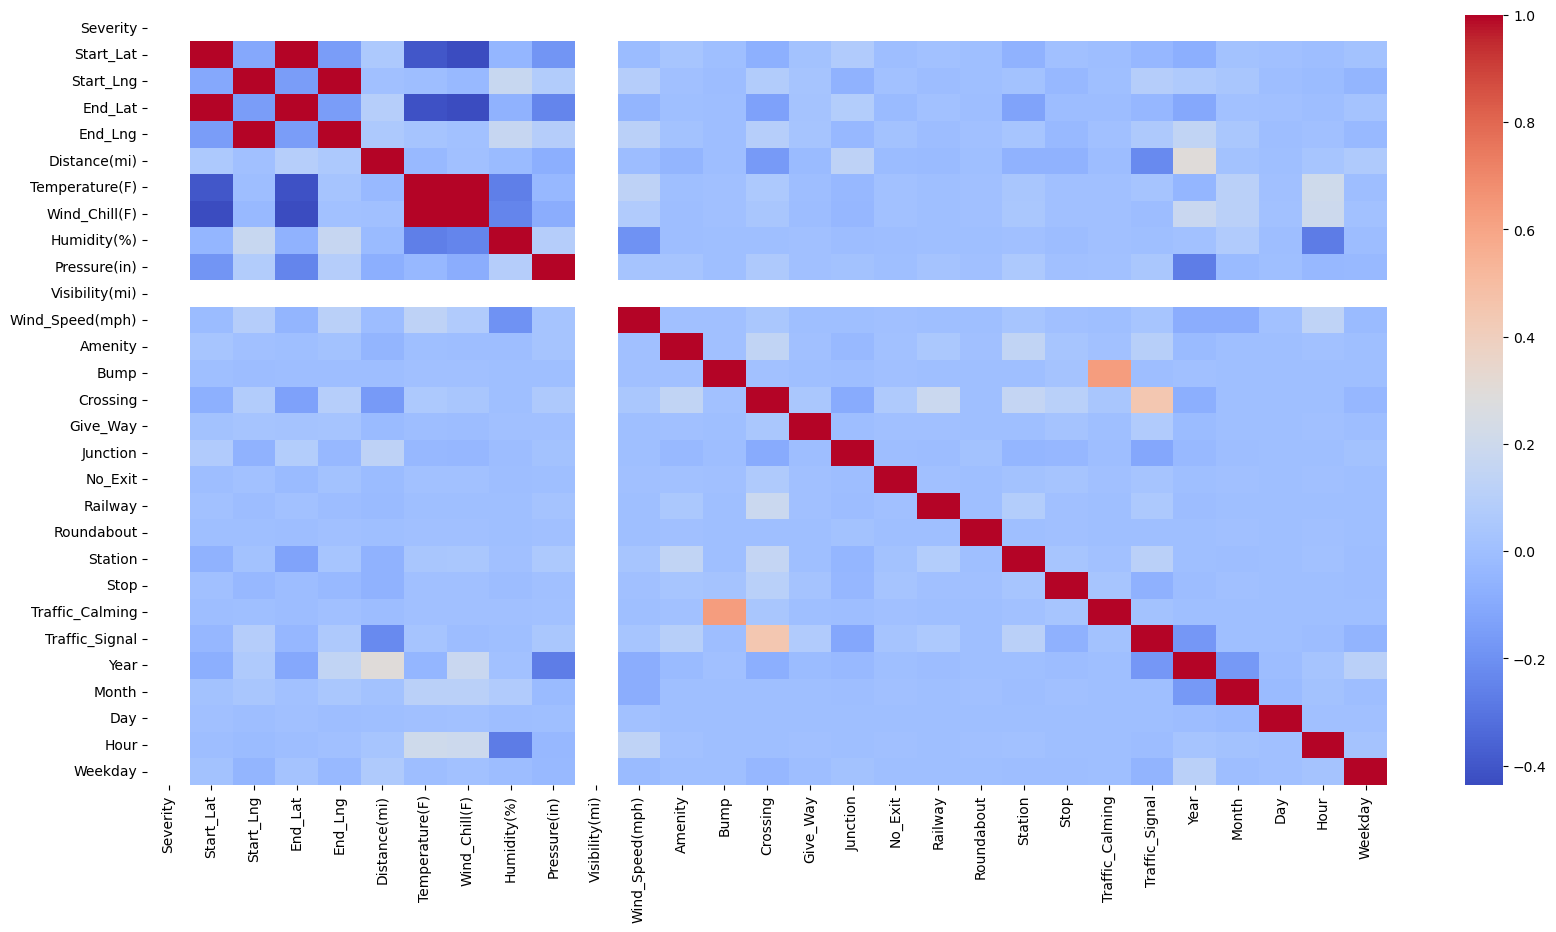

In [43]:
plt.figure(figsize=(20,10))
sns.heatmap(accidents_cleaned.select_dtypes(exclude="object").corr(), annot=False, cmap="coolwarm")
plt.show()

It can be seen that Start_Lat and End_Lat are highly correlated (100%) and similarly Start_Lng and End_Lng are higlty correlated, so we'll drop one of these features. Similarly Temperature and Wind Chill are higly correlated so we will drop the Wind_Chill(F) feature.

In [44]:
features_to_drop_corr = ["End_Lat", "End_Lng", "Wind_Chill(F)"]

accidents_cleaned = accidents_cleaned.drop(
    columns=features_to_drop_corr
    )

accidents_encoded_scaled = accidents_encoded_scaled.drop(
    columns=features_to_drop_corr
    )

## 3.7 Number of Accidents by Various Features

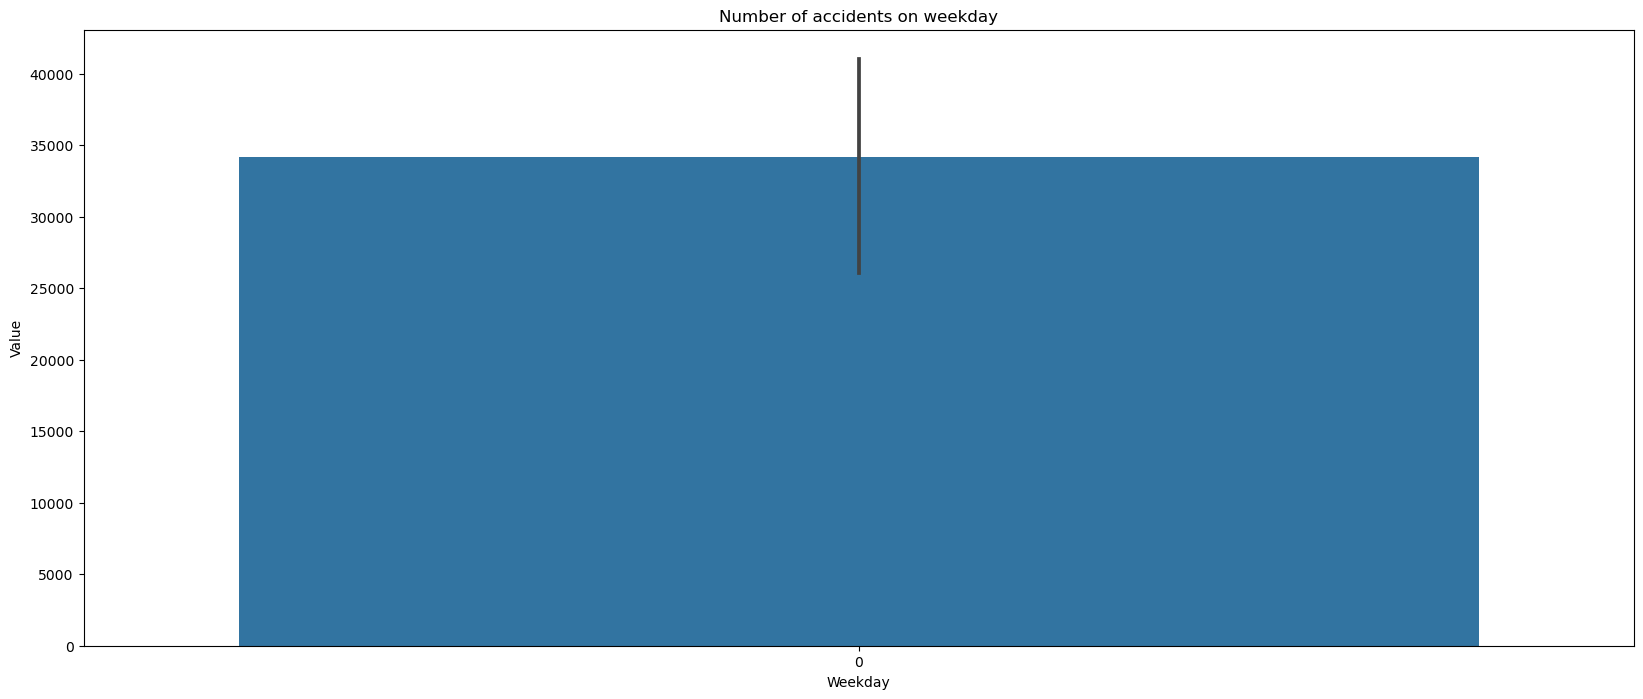

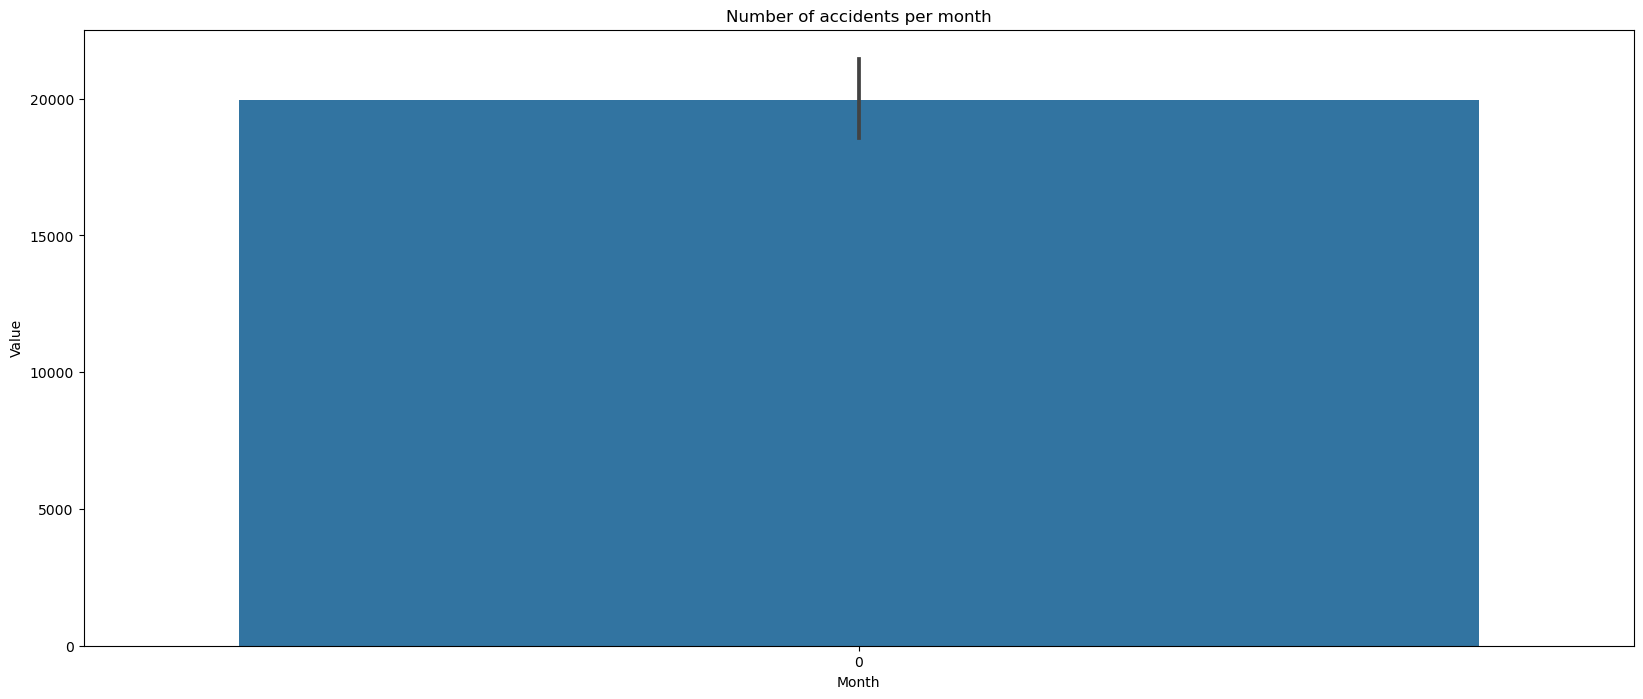

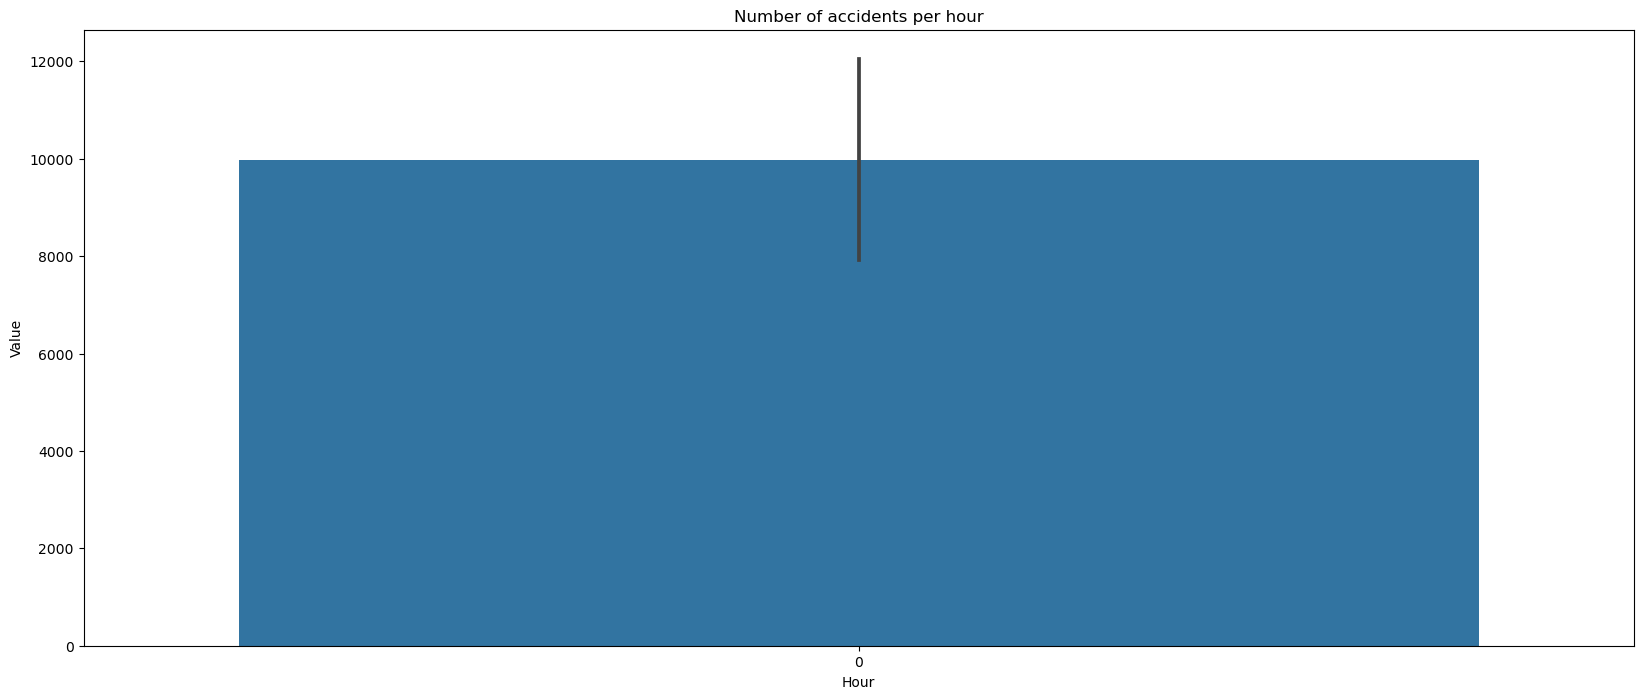

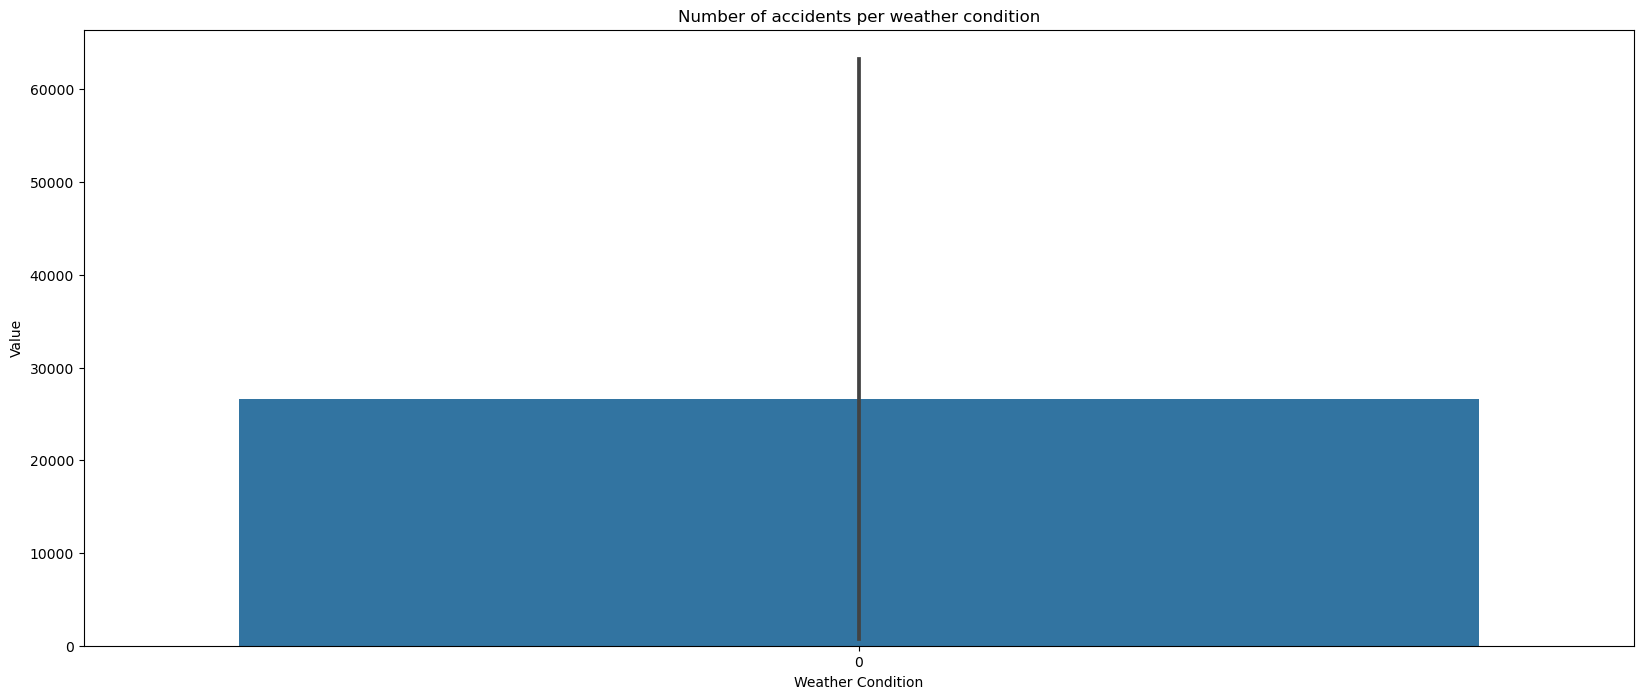

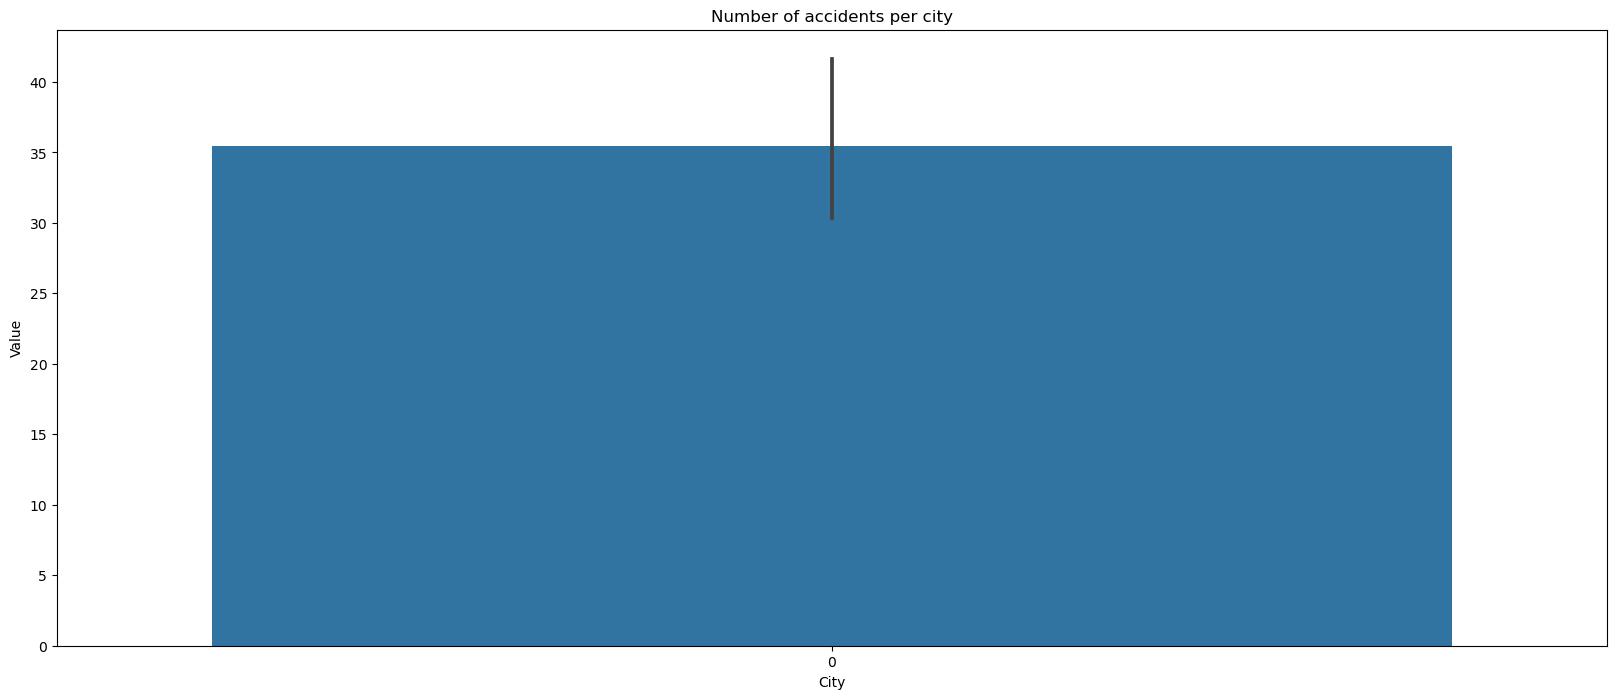

In [45]:
# Number of accidents by weekday
counts = accidents_cleaned['Weekday'].value_counts()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(20, 8))
plt.title("Number of accidents on weekday")
sns.barplot(counts.values)
plt.xlabel("Weekday")
plt.ylabel("Value")
plt.show()

# Number of accidents per month
counts = accidents_cleaned['Month'].value_counts()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure(figsize=(20, 8))
plt.title("Number of accidents per month")
sns.barplot(counts.values)
plt.xlabel("Month")
plt.ylabel("Value")
plt.show()

# Number of accidents per hour
counts = accidents_cleaned['Hour'].value_counts()
hours = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"]
plt.figure(figsize=(20, 8))
plt.title("Number of accidents per hour")
sns.barplot(counts.values)
plt.xlabel("Hour")
plt.ylabel("Value")
plt.show()

# Number of accidents per weather condition
counts = accidents_cleaned['Weather_Condition'].value_counts()
weather_conditions = ["Clear", "Cloudy", "Fog", "Rain", "Sand", "Smoke", "Snow", "Thunderstorm", "Windy"]
plt.figure(figsize=(20, 8))
plt.title("Number of accidents per weather condition")
sns.barplot(counts.values)
plt.xlabel("Weather Condition")
plt.ylabel("Value")
plt.show()

# Number of accidents per city
counts = accidents_cleaned['City'].value_counts()
cities = accidents_cleaned['City'].unique()
plt.figure(figsize=(20, 8))
plt.title("Number of accidents per city")
sns.barplot(counts.values)
plt.xlabel("City")
plt.ylabel("Value")
plt.show()


## 3.8 Year Wise Accidents Count

Let's see the accident's count across different years. This helps to better understand if the number of accidents happening each year has increase or decresed and will help in understanding the trend if there is any.

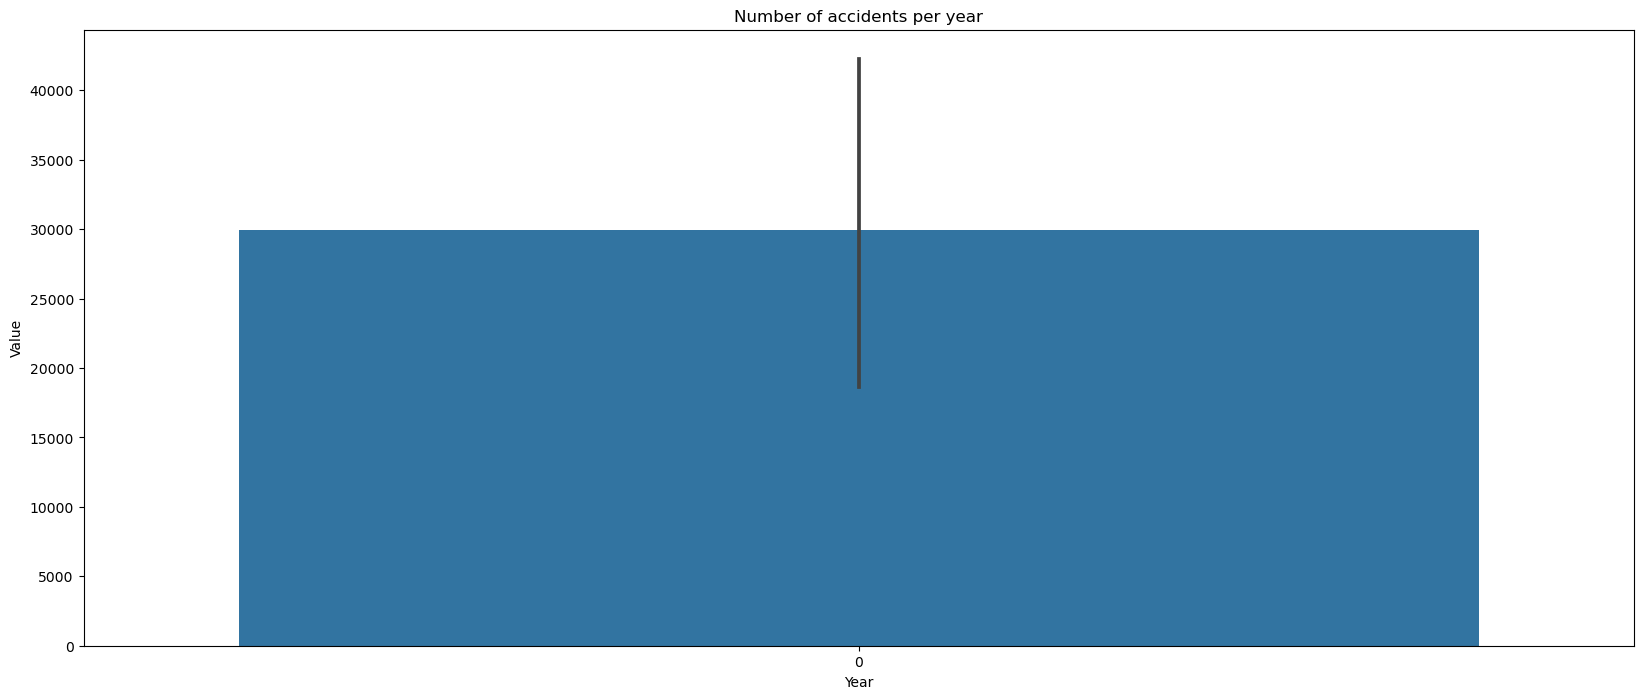

In [46]:
counts = accidents_cleaned['Year'].value_counts()
years = list(range(2016, 2022))
plt.figure(figsize=(20, 8))
plt.title("Number of accidents per year")
sns.barplot(counts.values)
plt.xlabel("Year")
plt.ylabel("Value")
plt.show()

## 3.9 Accidents Count Based on Weather Conditions

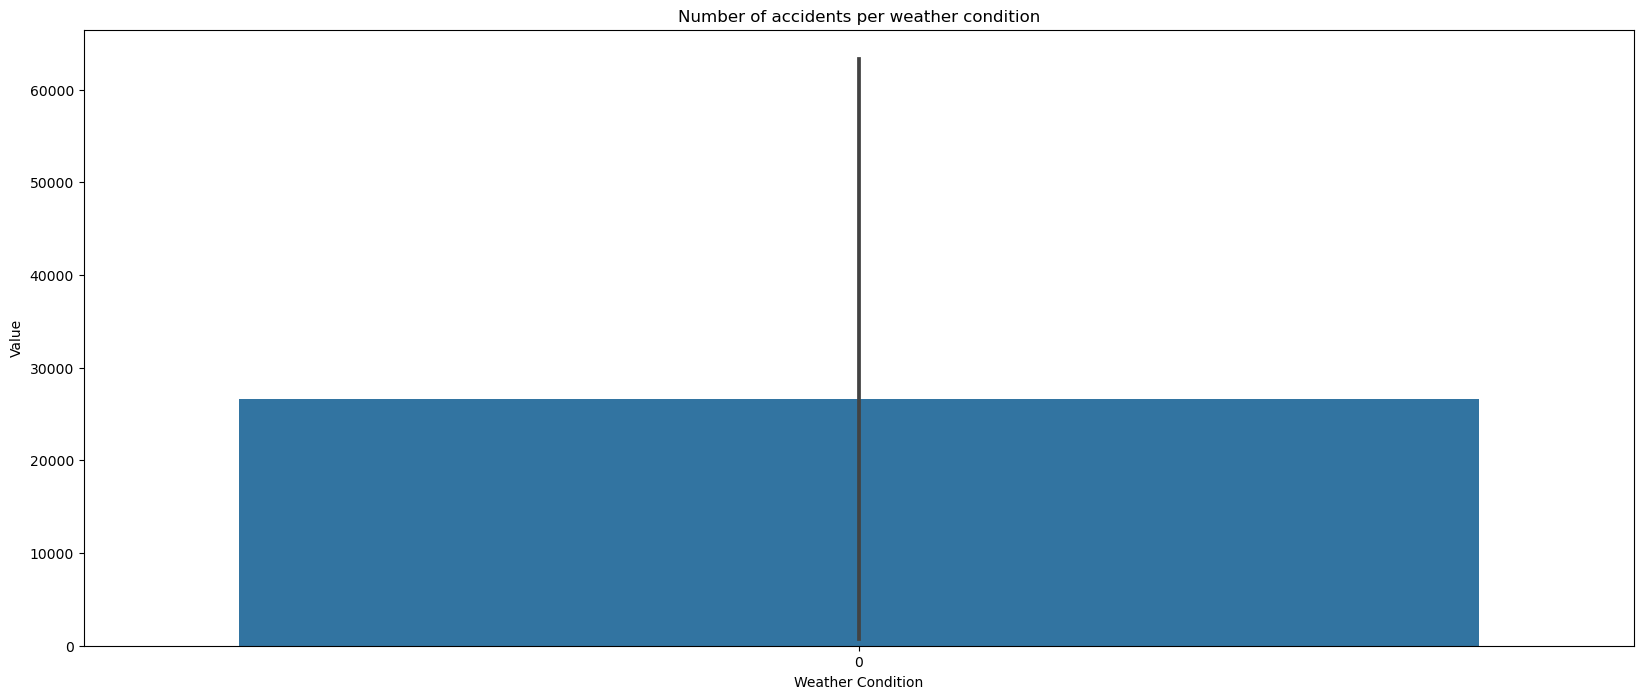

In [47]:
counts = accidents_cleaned['Weather_Condition'].value_counts()
weather_conditions = ["Clear", "Cloudy", "Fog", "Rain", "Sand", "Smoke", "Snow", "Thunderstorm", "Windy"]
plt.figure(figsize=(20, 8))
plt.title("Number of accidents per weather condition")
sns.barplot(counts.values)
plt.xlabel("Weather Condition")
plt.ylabel("Value")
plt.show()

## 3.10 Violin Plot

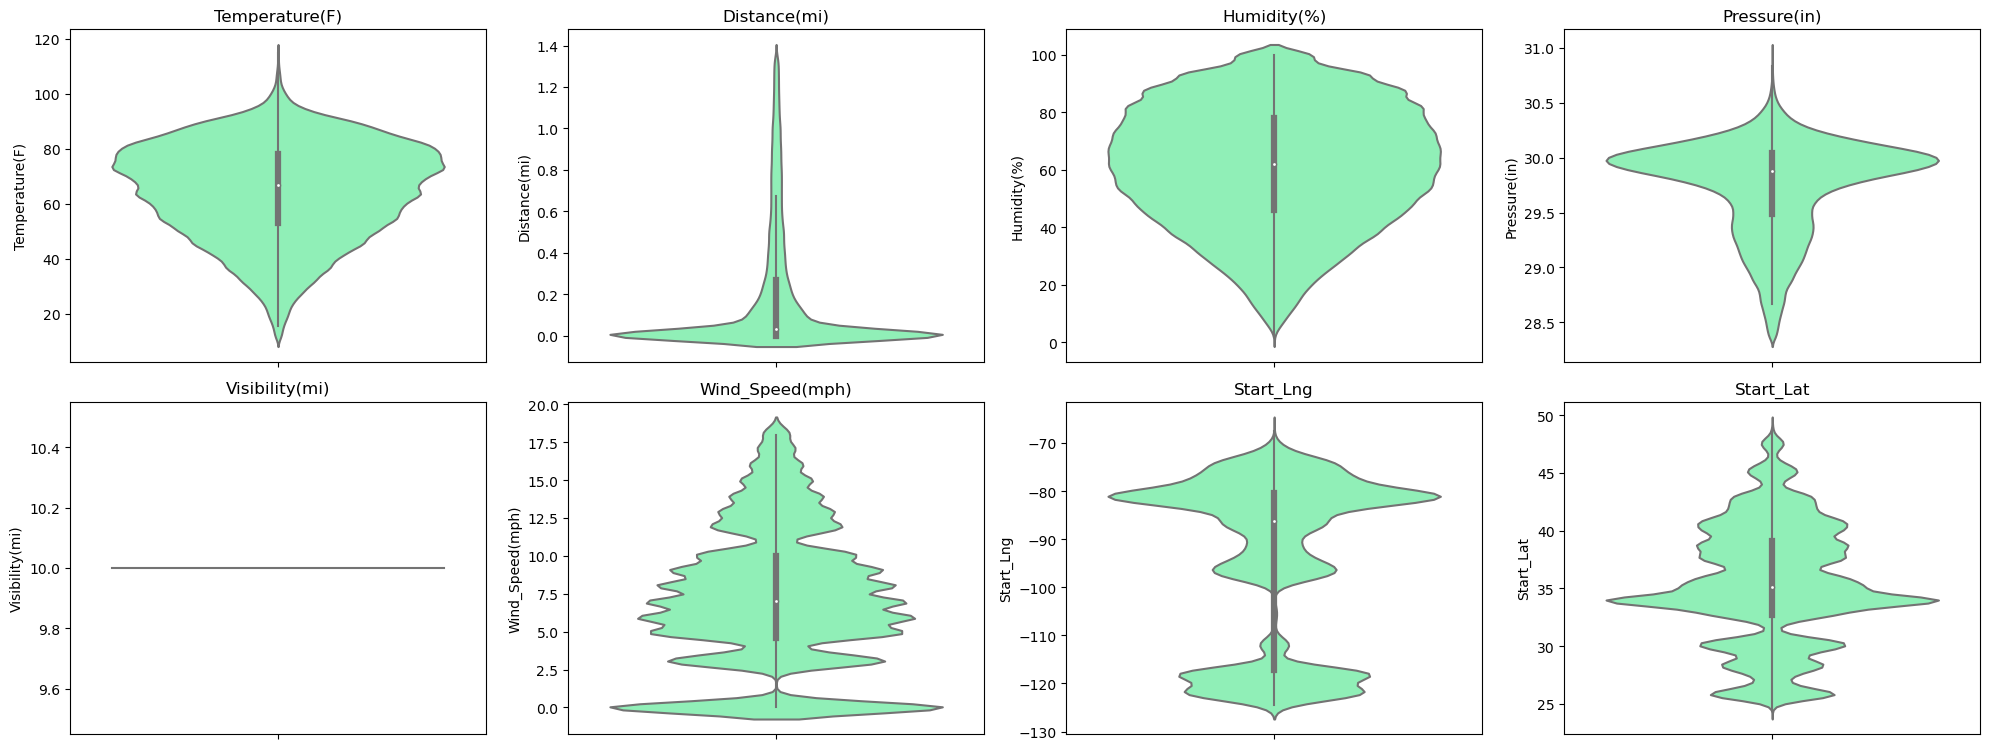

In [48]:
# Define the features for which you want to create violin plots
features = ['Temperature(F)', 'Distance(mi)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Start_Lng', 'Start_Lat']

# Create a figure and set its size
plt.figure(figsize=(20, 15))

# Loop through the features and create a violin plot for each
for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.violinplot(y=accidents_cleaned[feature], palette='rainbow')
    plt.title(feature)
    plt.tight_layout()

# Show the plot
plt.show()

Temperature and Humidity looks to be normally distributed, when the others are not.

## 3.11 QQ Plots

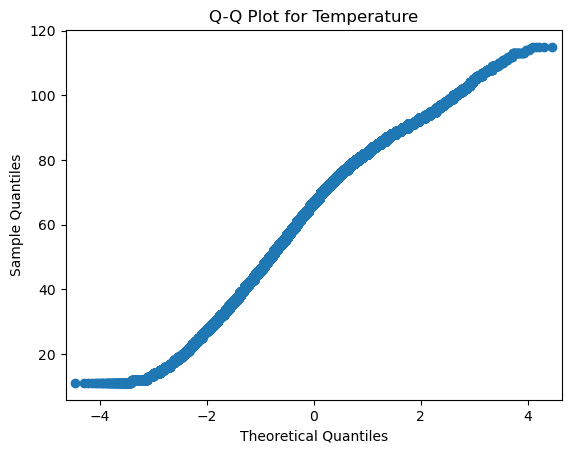

In [49]:
# QQ plot for Temperature(F)

sm.qqplot(accidents_cleaned["Temperature(F)"])
plt.title('Q-Q Plot for Temperature')
plt.show()

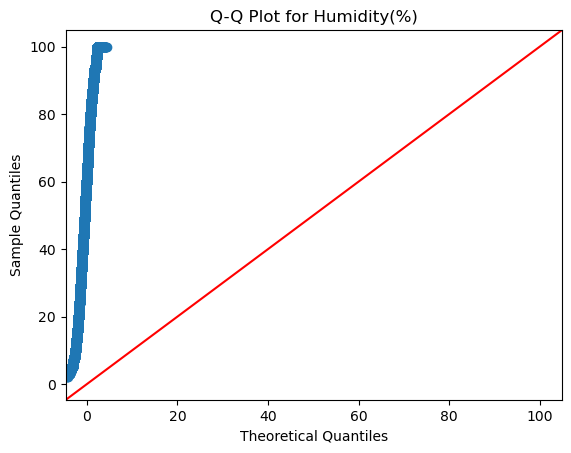

In [50]:
# QQ Plot for Humidity(%)

sm.qqplot(accidents_cleaned['Humidity(%)'], line ='45')
plt.title('Q-Q Plot for Humidity(%)')
plt.show()

Though the violin plot was misleading and looked like the features were normally distributed from the QQ plot we can see that Temperature and Humidity is not normally distributed.

# Train Test Split

Before training our model we have to split the dataset into training and testing set. We do this so that we can evaluvate the model performance on how it will perform on unseen data.

In [51]:
features = accidents_encoded_scaled.drop("Severity", axis=1)
label = accidents_encoded_scaled["Severity"]
train_features, test_features, train_label, test_label = train_test_split(features, label, test_size=0.2, random_state=42)

# Handling Data Imbalance

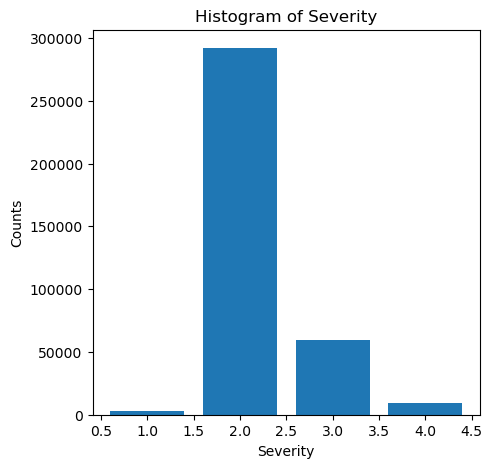

In [52]:
severity_counts = train_label.value_counts()

plt.figure(figsize=(5, 5))
plt.title("Histogram of Severity")
plt.bar(severity_counts.index.tolist(), severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Counts")
plt.show()

It is evident from the barplot above that the dataset is heavily imbalanced. Majority of the accidents fall into the "Severity 2" category.

There are few drawbacks of fitting the model to an unbalanced dataset:

1.   When one class has a much larger representation in the data, the model prioritizes learning its patterns. This can result in good accuracy overall, but poor performance for the minority class. The model might simply predict the majority class every time because it achieves a high success rate that way, even if it's not very informative.
2.   The model may not perform well on unseen data that has a different class distribution.

Thus there is a need for us to balance the dataset before fitting the model to the data. There are several up-sampling and down-sampling techniques available, but we'll be using Random Under Sampler and Synthetic Minority Over-sampling Technique (SMOTE).

First, we'll use the "Random Under Sampler" to under sample the majority class. Then we'll upsample all the other classes using SMOTE.

This ensures that the data is balanced and the model is not biased towards a single class.

In [53]:
intermediate_dataset = deepcopy(train_features)
intermediate_dataset["Severity"] = train_label

intermediate_dataset_1 = intermediate_dataset[
    intermediate_dataset["Severity"].isin([2, 3])
    ]

intermediate_dataset_2 = intermediate_dataset[
    intermediate_dataset["Severity"].isin([1, 4])
    ]

sampler = RandomUnderSampler(sampling_strategy="majority")
resampled_features, resampled_label = sampler.fit_resample(
    intermediate_dataset_1.drop(columns=["Severity"]), intermediate_dataset_1["Severity"]
)

resampled_dataset = resampled_features
resampled_dataset["Severity"] = resampled_label

resampled_dataset = pd.concat([resampled_dataset, intermediate_dataset_2])
resampled_dataset.Severity.value_counts()

resampled_dataset_features = resampled_dataset.drop(columns=["Severity"])
resampled_dataset_label = resampled_dataset["Severity"]

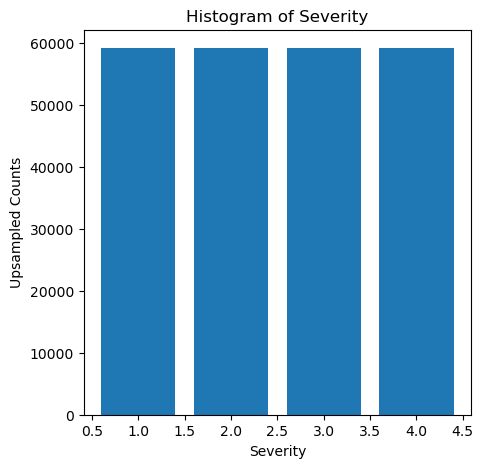

In [54]:
smote_sampler = SMOTE(random_state=100)

upsampled_features, upsampled_label = smote_sampler.fit_resample(
    resampled_dataset_features,
    resampled_dataset_label
    )

severity_counts = upsampled_label.value_counts()

plt.figure(figsize=(5, 5))
plt.title("Histogram of Severity")
plt.bar(severity_counts.index.tolist(), severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Upsampled Counts")
plt.show()

We'll also downsample the data and fit a model to both upsampled and downsampled data to see which fits our purpose better.

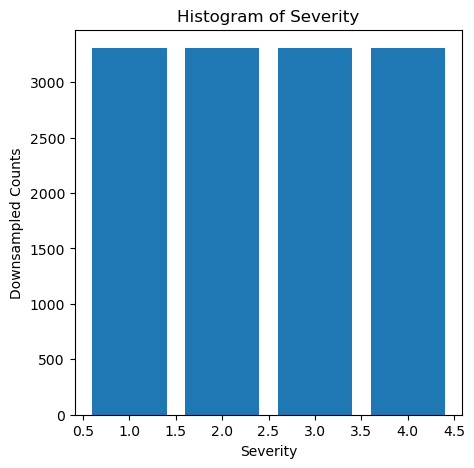

In [55]:
sampler = RandomUnderSampler(sampling_strategy="all", random_state =100)
downsampled_features, downsampled_label = sampler.fit_resample(
    train_features, train_label
)

downsampled_label.value_counts()

severity_counts = downsampled_label.value_counts()

plt.figure(figsize=(5, 5))
plt.title("Histogram of Severity")
plt.bar(severity_counts.index.tolist(), severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Downsampled Counts")
plt.show()

Now, fit the model to the upsampled and downsampled data.

In [56]:
rfc = RandomForestClassifier(
    n_jobs=-1,
    random_state=100,
    n_estimators=200,
    max_depth=30,
    criterion="gini"
    )

upsampled_rfc = rfc.fit(upsampled_features, upsampled_label)
u_score = upsampled_rfc.score(test_features, test_label)

downsampled_rfc = rfc.fit(downsampled_features, downsampled_label)
d_score = downsampled_rfc.score(test_features, test_label)

print("Test Score (Upsampled Data):", u_score)
print("Test Score (Downsampled Data):", d_score)

Test Score (Upsampled Data): 0.7274426788365316
Test Score (Downsampled Data): 0.5436630560290318


From the above results it looks like the model fits the upsampled data better. Thus, we'll stick to using the upsampled data for building our models.

# Storing Processed Data

In [57]:
# Storing DataFrame as Pickle
train_features.to_pickle("train_features.pkl")
train_label.to_pickle("train_label.pkl")
test_features.to_pickle("test_features.pkl")
test_label.to_pickle("test_label.pkl")

upsampled_features.to_pickle("upsampled_features.pkl")
upsampled_label.to_pickle("upsampled_label.pkl")
downsampled_features.to_pickle("downsampled_features.pkl")
downsampled_label.to_pickle("downsampled_label.pkl")

In [58]:
with open("train_features.pkl", "rb") as file:
    train_features = pickle.load(file)

with open("train_label.pkl", "rb") as file:
    train_label = pickle.load(file)

with open("test_features.pkl", "rb") as file:
    test_features = pickle.load(file)

with open("test_label.pkl", "rb") as file:
    test_label = pickle.load(file)

with open("upsampled_features.pkl", "rb") as file:
    upsampled_features = pickle.load(file)

with open("upsampled_label.pkl", "rb") as file:
    upsampled_label = pickle.load(file)

with open("downsampled_features.pkl", "rb") as file:
    downsampled_features = pickle.load(file)

with open("downsampled_label.pkl", "rb") as file:
    downsampled_label = pickle.load(file)

# Model Fitting

## Display Classification Metrics

The below function is written to calculate the below metrics for the models trained:
*   Precision
*   Recall
*   F1 Score
*   Accuracy
*   Confusion Matrix
*   RoC Curve

In [85]:
def display_metrics(model, test_features, test_label):
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, roc_curve, roc_auc_score
    from sklearn.preprocessing import LabelBinarizer

    test_label_pred = model.predict(test_features)
    test_label_pred_prob = model.predict_proba(test_features)

    ConfusionMatrixDisplay.from_predictions(test_label, test_label_pred)

    print(classification_report(test_label, test_label_pred))

    label_binarizer = LabelBinarizer().fit(train_label)
    test_label_onehot = label_binarizer.transform(test_label)

    num_rows = 2
    num_cols = 2

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 6))

    for idx in range(len(model.classes_)):

        fpr, tpr, _ = roc_curve(test_label_onehot[:, idx].ravel(), test_label_pred_prob[:, idx].ravel())
        
        row = idx // num_cols
        col = idx % num_cols
        
        axes[row, col].step(fpr, tpr, where="post")
        axes[row, col].set_title(f"ROC Curve - Severity {model.classes_[idx]} VS Rest")
        axes[row, col].set_xlabel("False Positive Rate")
        axes[row, col].set_ylabel("True Positive Rate")
        axes[row, col].set_xlim([0, 1])
        axes[row, col].set_ylim([0, 1])

        auc_score = roc_auc_score(test_label_onehot[:, idx].ravel(), test_label_pred_prob[:, idx].ravel(), multi_class="ovr")
        print(f"AUC Score - Severity {model.classes_[idx]} VS Rest: {round(auc_score, 4)}")

    plt.tight_layout()
    plt.show()

Now that the data is cleaned and ready we'll fit different models to our data and compare their performance and find the one that performs better than the others.

## Logistic Regression

We'll start by fitting a basic "Logistic Regression Model". We use the LogisticRegressionCV model from scikit learn. Choosing this helps us to eliminate the manual work of tuning the regularisation parameter.

Since the dataset we have chosen is quite large, tuning the hyperparameters is very compute intensive. Thus, we'll downsample the dataset to use GridSearchCV for searching for the best set of parameters for the model and fit the actual model with the upsampled data which will provide good accuracy.

Though always not advised we can use a subset of data for tuning the hyperparameters when:
*   When the dataset is very large running grid search on the entire dataset is computationally expensive and time-consuming.
*   Once we have suitable hyperparameter evaluate it on the full dataset.

In [72]:
lrcv = LogisticRegressionCV(n_jobs=-1, random_state=100)
parameters = {"solver": ["newton-cg", "saga"]}

grid = RandomizedSearchCV(lrcv, parameters, n_jobs=-1, verbose=5, random_state=100)
grid.fit(downsampled_features, downsampled_label)

print("Best Parameters:")
print(grid.best_params_)
print("Test Score:", grid.score(test_features, test_label))

c:\Users\ajayv\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters:
{'solver': 'newton-cg'}
Test Score: 0.4197503711442239


Using RandomizedSearchCV we have found the best set of hyperparameters for logistic regression model as below:
*   solver: newton-cg

In [59]:
lrcv = LogisticRegressionCV(n_jobs=-1, random_state=100, solver="newton-cg")
lrcv.fit(upsampled_features, upsampled_label)

with open("logistic-regression.pkl", "wb") as file:
    pickle.dump(lrcv, file)

print("Test Score:", lrcv.score(test_features, test_label))

Test Score: 0.4840930334854566


c:\Users\ajayv\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.04      0.65      0.07       793
           2       0.91      0.46      0.61     73188
           3       0.34      0.60      0.44     14691
           4       0.06      0.37      0.10      2263

    accuracy                           0.48     90935
   macro avg       0.34      0.52      0.31     90935
weighted avg       0.79      0.48      0.57     90935

AUC Score - Severity 1 VS Rest: 0.8297
AUC Score - Severity 2 VS Rest: 0.6981
AUC Score - Severity 3 VS Rest: 0.7403
AUC Score - Severity 4 VS Rest: 0.6913


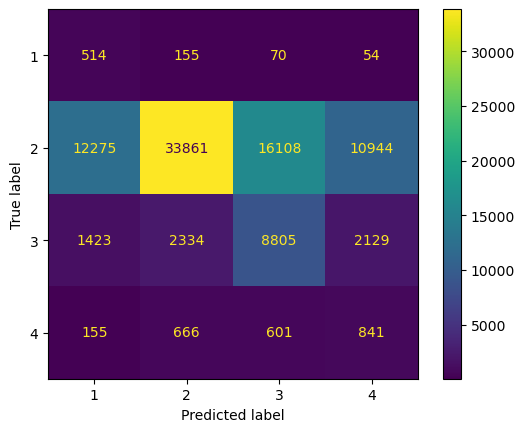

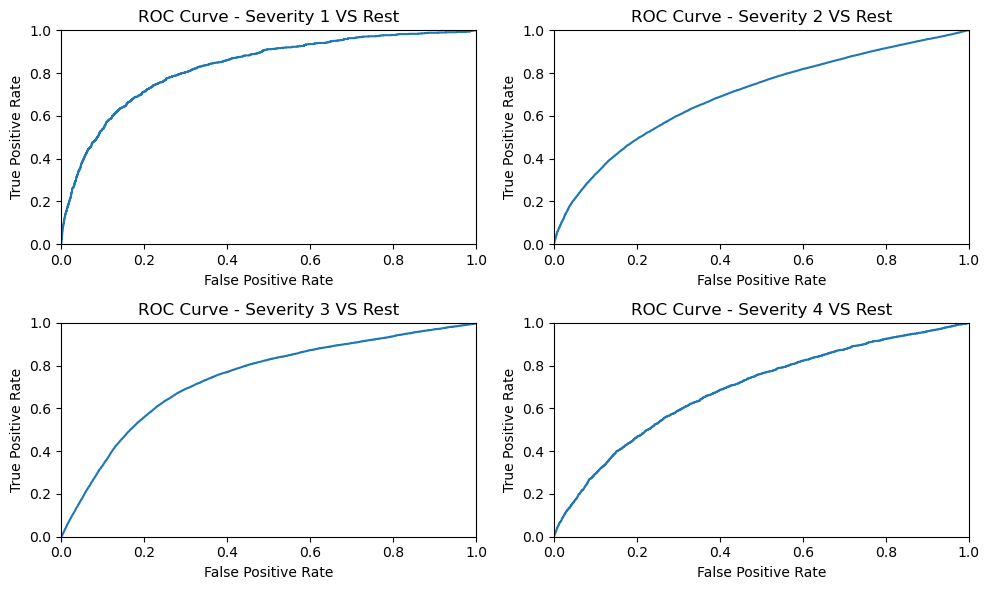

In [86]:
# Model Metrics for Logistic Regression
display_metrics(lrcv, test_features, test_label)

## Categorical Naive Bayes Classifier

In [66]:
gnb = CategoricalNB(min_categories=test_label.nunique())
gnb.fit(upsampled_features, upsampled_label)

print("Test Score:", gnb.score(test_features, test_label))

Test Score: 0.2429097707153461


              precision    recall  f1-score   support

           1       0.02      0.44      0.03       793
           2       0.90      0.19      0.31     73188
           3       0.24      0.47      0.32     14691
           4       0.04      0.46      0.08      2263

    accuracy                           0.24     90935
   macro avg       0.30      0.39      0.18     90935
weighted avg       0.76      0.24      0.30     90935

AUC Score - Severity 1 VS Rest: 0.6744
AUC Score - Severity 2 VS Rest: 0.5487
AUC Score - Severity 3 VS Rest: 0.6464
AUC Score - Severity 4 VS Rest: 0.6481


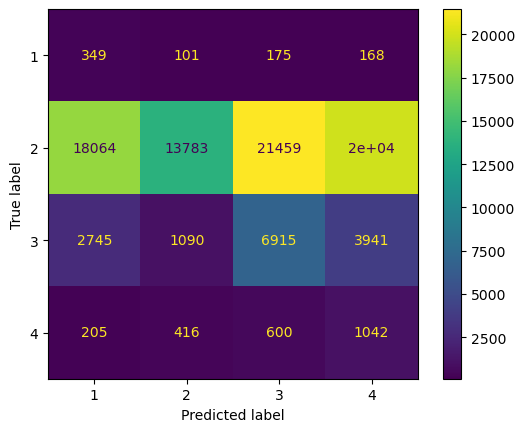

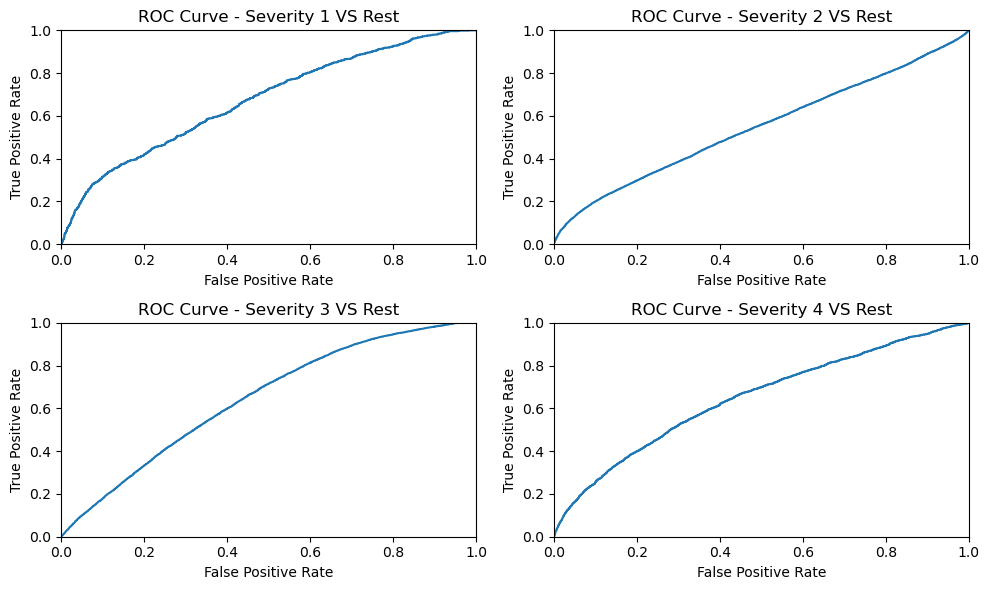

In [88]:
# Model Metrics for Categorical Naive Bayes
display_metrics(gnb, test_features, test_label)

## K-NN Classifier

In [67]:
knn = KNeighborsClassifier(n_jobs=-1)
parameters = {"algorithm": ["ball_tree", "kd_tree"], "weights": ["uniform", "distance"], "n_neighbors": [20, 30, 50, 100, 150]}

grid = RandomizedSearchCV(knn, parameters, verbose=5, n_jobs=-1, random_state=100)
grid.fit(downsampled_features, downsampled_label)

print("Best Parameters:")
print(grid.best_params_)
print("Test Score:", grid.score(test_features, test_label))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:
{'weights': 'distance', 'n_neighbors': 100, 'algorithm': 'kd_tree'}
Test Score: 0.29017430032440755


Using RandomizedSearchCV we have found the best set of hyperparameters for k-NN classifier model as below:
*   weights: distance
*   n_neighbors: 100
*   algorithm: kd_tree

In [68]:
knn = KNeighborsClassifier(algorithm="kd_tree", weights="distance", n_neighbors=100, n_jobs=-1)
knn.fit(upsampled_features, upsampled_label)

with open("knn.pkl", "wb") as file:
    pickle.dump(knn, file)

print("Test Score:", knn.score(test_features, test_label))

Test Score: 0.2354758893715291


              precision    recall  f1-score   support

           1       0.02      0.73      0.04       793
           2       0.93      0.18      0.29     73188
           3       0.32      0.46      0.38     14691
           4       0.05      0.58      0.09      2263

    accuracy                           0.24     90935
   macro avg       0.33      0.48      0.20     90935
weighted avg       0.80      0.24      0.30     90935

AUC Score - Severity 1 VS Rest: 0.7737
AUC Score - Severity 2 VS Rest: 0.625
AUC Score - Severity 3 VS Rest: 0.7238
AUC Score - Severity 4 VS Rest: 0.7052


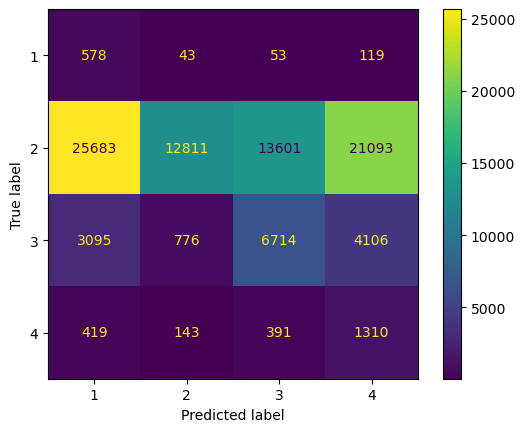

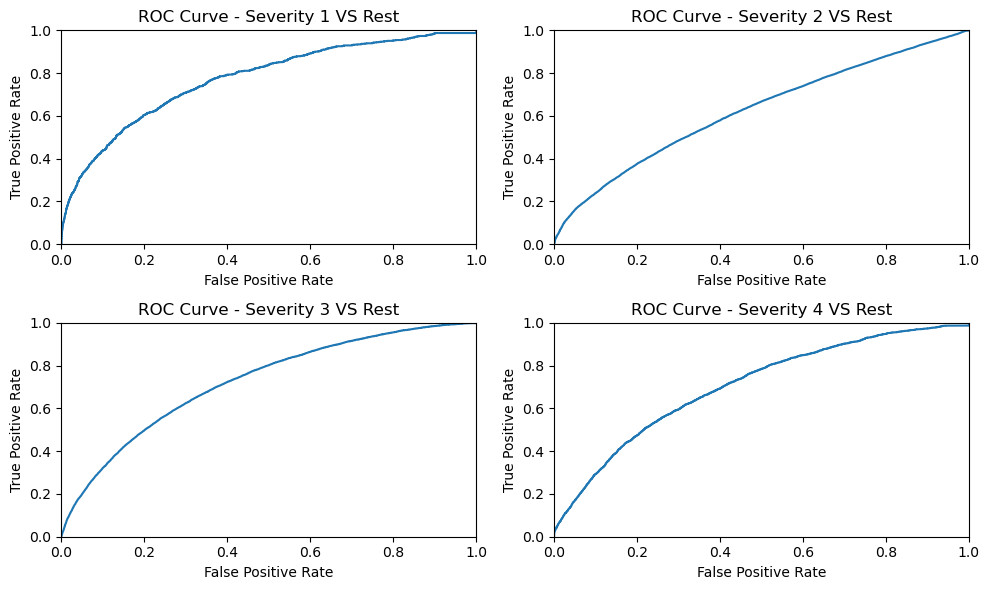

In [89]:
# Model Metrics for KNN
display_metrics(knn, test_features, test_label)

## Decision Tree

In [91]:
dtc = DecisionTreeClassifier(random_state=100)
parameters = [{"criterion": ["gini"], "max_depth": [10, 15, 30, 50]}]
grid = GridSearchCV(dtc, parameters, verbose=5, n_jobs=-1)
grid.fit(upsampled_features, upsampled_label)

print("Best Parameters:")
print(grid.best_params_)
print("Test Score:", grid.score(test_features, test_label))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters:
{'criterion': 'gini', 'max_depth': 15}
Test Score: 0.6924066641007313


Using GridSearchCV we have found the best set of hyperparameters for Decision Tree model as below:
*   criterion: gini
*   max_depth: 15

              precision    recall  f1-score   support

           1       0.23      0.80      0.36       793
           2       0.95      0.68      0.79     73188
           3       0.40      0.81      0.54     14691
           4       0.14      0.41      0.20      2263

    accuracy                           0.69     90935
   macro avg       0.43      0.67      0.47     90935
weighted avg       0.84      0.69      0.73     90935

AUC Score - Severity 1 VS Rest: 0.9334
AUC Score - Severity 2 VS Rest: 0.813
AUC Score - Severity 3 VS Rest: 0.8457
AUC Score - Severity 4 VS Rest: 0.8074


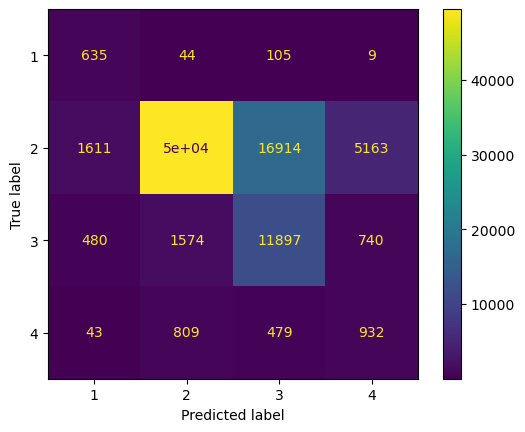

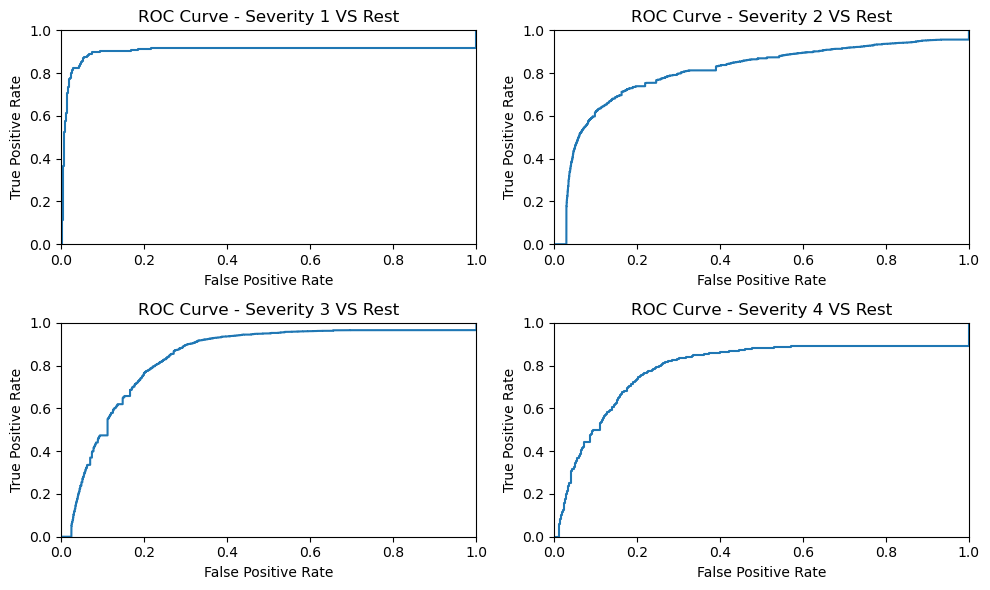

In [94]:
# Model Metrics for Decision Tree Classifier
dtc = grid.best_estimator_
display_metrics(dtc, test_features, test_label)

## Random Forest

In [70]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_jobs=-1, random_state=100)
parameters = [{"n_estimators": [200, 500], "max_depth": [15, 30, 50]}]
grid = RandomizedSearchCV(rfc, parameters, verbose=5, n_jobs=-1, random_state=100)
grid.fit(downsampled_features, downsampled_label)

print("Best Parameters:")
print(grid.best_params_)
print("Test Score:", grid.score(test_features, test_label))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\ajayv\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:
{'n_estimators': 500, 'max_depth': 30}
Test Score: 0.5405399461153572


Using RandomizedSearchCV we have found the best set of hyperparameters for Random Forest model as below:
*   n_estimators: 500
*   max_depth: 30

In [71]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_jobs=-1, random_state=100, n_estimators=500, max_depth=30)
rfc.fit(upsampled_features, upsampled_label)

with open("random-forest.pkl", "wb") as file:
    pickle.dump(rfc, file)

print("Test Score:", rfc.score(test_features, test_label))

Test Score: 0.7294990927585638


              precision    recall  f1-score   support

           1       0.33      0.74      0.45       793
           2       0.96      0.72      0.82     73188
           3       0.42      0.84      0.56     14691
           4       0.20      0.44      0.28      2263

    accuracy                           0.73     90935
   macro avg       0.48      0.68      0.53     90935
weighted avg       0.85      0.73      0.76     90935

AUC Score - Severity 1 VS Rest: 0.9733
AUC Score - Severity 2 VS Rest: 0.8764
AUC Score - Severity 3 VS Rest: 0.8861
AUC Score - Severity 4 VS Rest: 0.8809


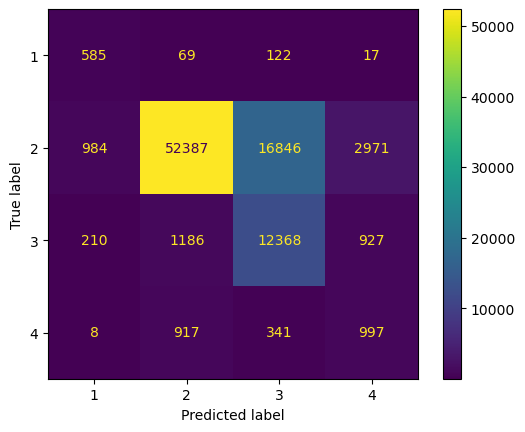

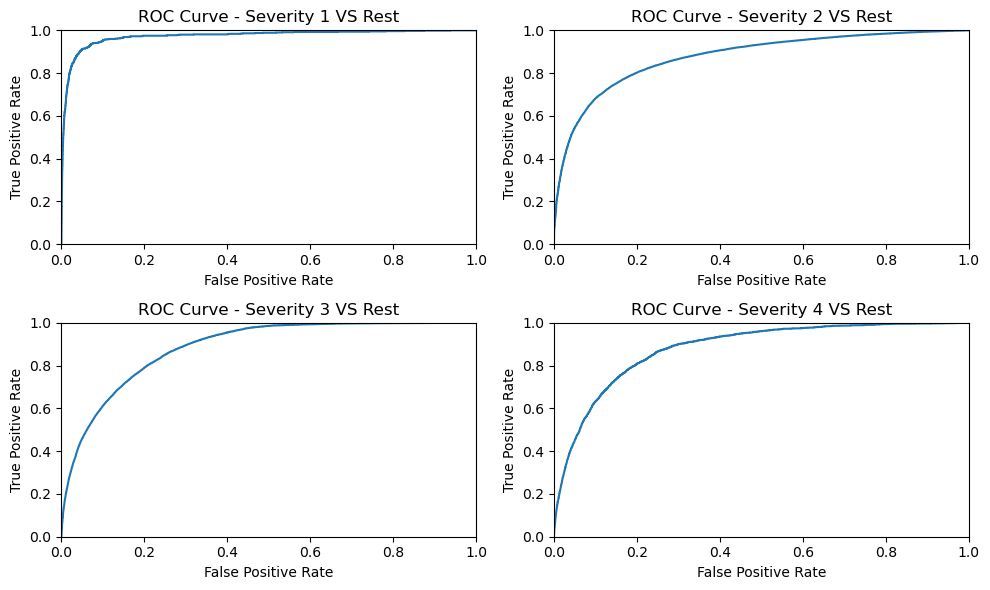

In [95]:
# Model Metrics for Random Forest Classifier
display_metrics(rfc, test_features, test_label)

## Ada Boost

In [72]:
adb = AdaBoostClassifier(random_state=100, algorithm="SAMME.R")
parameters = {"n_estimators": [200 , 500]}
grid = RandomizedSearchCV(adb, parameters, verbose=5, n_jobs=-1, random_state=100)
grid.fit(downsampled_features, downsampled_label)

print("Best Parameters:")
print(grid.best_params_)
print("Test Score:", grid.score(test_features, test_label))

c:\Users\ajayv\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters:
{'n_estimators': 200}
Test Score: 0.47730796722933966


Using RandomizedSearchCV we have found the best set of hyperparameters for Random Forest model as below:
*   n_estimators: 200

In [73]:
adb = AdaBoostClassifier(random_state=100, algorithm="SAMME.R", n_estimators=200)
adb.fit(upsampled_features, upsampled_label)

with open("adb.pkl", "wb") as file:
    pickle.dump(adb, file)

print("Test Score:", adb.score(test_features, test_label))

Test Score: 0.6056633859350086


              precision    recall  f1-score   support

           1       0.15      0.64      0.25       793
           2       0.92      0.60      0.72     73188
           3       0.35      0.68      0.47     14691
           4       0.08      0.43      0.14      2263

    accuracy                           0.61     90935
   macro avg       0.38      0.59      0.39     90935
weighted avg       0.80      0.61      0.66     90935

AUC Score - Severity 1 VS Rest: 0.9551
AUC Score - Severity 2 VS Rest: 0.6286
AUC Score - Severity 3 VS Rest: 0.7859
AUC Score - Severity 4 VS Rest: 0.7754


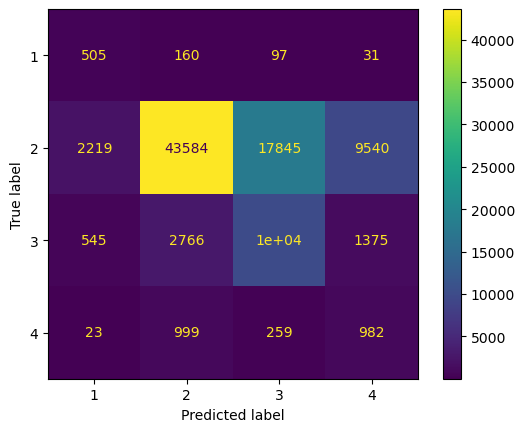

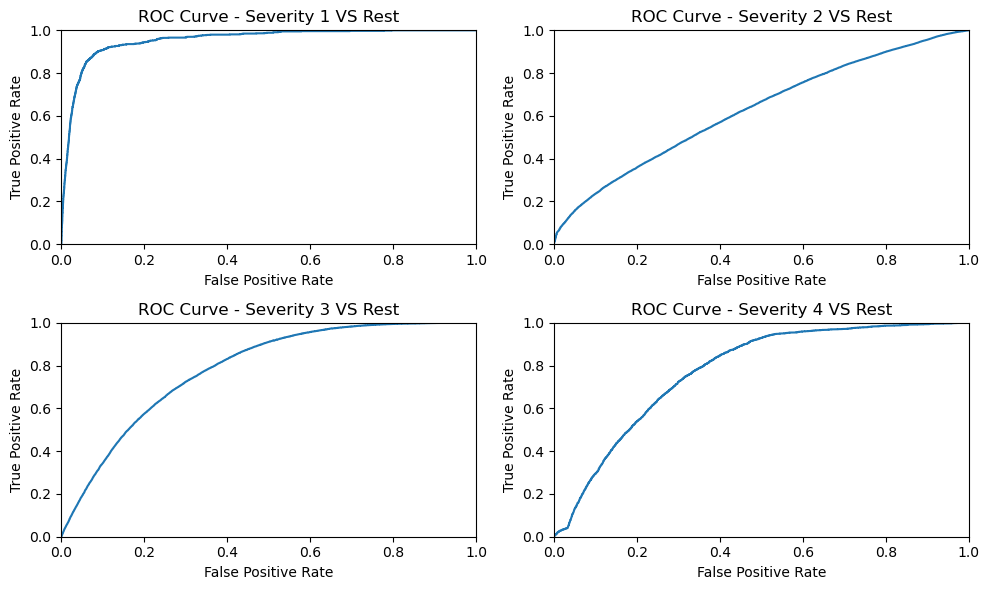

In [96]:
# Model Metrics for Ada Boost Classifier
display_metrics(adb, test_features, test_label)

# Comapring Models' Performance

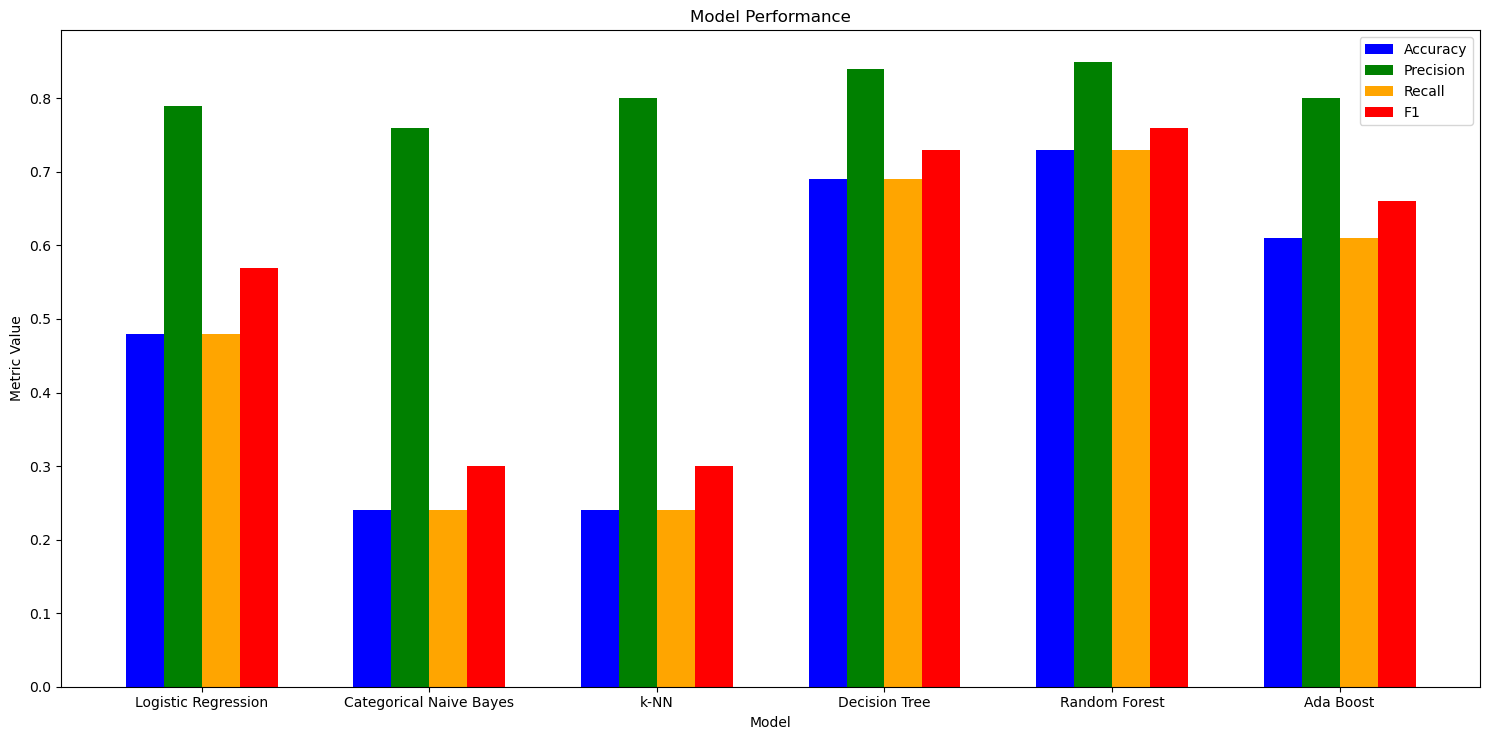

In [97]:
metrics_schema = ["Model", "Accuracy", "Precision", "Recall", "F1"]
metrics_df = [
	["Logistic Regression", 0.48, 0.79, 0.48, 0.57],
	["Categorical Naive Bayes", 0.24, 0.76, 0.24, 0.30],
	["k-NN", 0.24, 0.80, 0.24, 0.30],
	["Decision Tree", 0.69, 0.84, 0.69, 0.73],
	["Random Forest", 0.73, 0.85, 0.73, 0.76],
	["Ada Boost", 0.61, 0.80, 0.61, 0.66]
]

# Load data into DataFrame
df = pd.DataFrame(metrics_df, columns=metrics_schema)

n_models = len(df)
n_metrics = len(metrics_schema[1:])  # Exclude "Model" column

# Create single subplot
fig, ax = plt.subplots(figsize=(15, 7.5))

# Define color list for each metric
colors = ['blue', 'green', 'orange', 'red']

# X-axis positions (one for each model)
x = range(n_models)
bar_width = 0.25  # Adjust bar width for better visualization

# Group positions (offset for each metric within a group)
group_width = n_metrics * bar_width * 0.5  # Total width for each group
group_positions = [x[i] + i * group_width for i in range(n_models)]

# Create a single set of bars for each metric (to avoid duplicates in legend)
bar_containers = []
metric_labels = metrics_schema[1:]
for metric_index, metric in enumerate(metric_labels):
    bar_positions = [group_positions[i] + metric_index * bar_width for i in range(n_models)]
    bar_container = ax.bar(bar_positions, df.loc[:, metric], bar_width, label=metric, color=colors[metric_index])
    bar_containers.append(bar_container[0])  # Append the first bar object for each metric

# Set common labels and title
ax.set_xlabel("Model")
ax.set_ylabel("Metric Value")
plt.xticks([pos + bar_width * 1.5 for pos in group_positions], df['Model'])
plt.title("Model Performance")

# Add legend using the single bar objects from each metric
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), framealpha=0.8)
plt.tight_layout()
plt.show()

From the plot above, the Random Forest model appears to perform the best overall.

*	Accuracy: Random Forest has the highest accuracy (0.73) among the listed models. Accuracy represents the overall proportion of correctly classified instances.
*	Precision: Random Forest has the highest precision (0.85). Precision indicates the proportion of positive predictions that were truly positive.
*	Recall: Similar to precision, Random Forest has a good recall (0.73). Recall reflects the proportion of actual positive cases the model identified correctly.
*	F1-Score: This metric combines precision and recall, and Random Forest again achieves the highest F1-score (0.76). This suggests a good balance between identifying true positives and avoiding false positives.

However, it's important to consider a few things:

*	Limited Data: This analysis is based on a small dataset (6 models). With more data, the results might differ.
*	Problem Type: The best model can depend on the specific problem you're trying to solve.

In our case, since we are interested in categorizing the severity of an accident, the Random Forest model seems to be a good fit for the data.